# Airbnb Price Prediction

## 1. Load the data & import necessary packages

In [1]:
import  pandas as pd
import numpy as np
from numpy import sqrt
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import sklearn
from sklearn.preprocessing import Imputer, StandardScaler, OneHotEncoder, RobustScaler
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV,cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline

from statlearning import plot_dist, plot_feature_importance, plot_coefficients

import statsmodels.formula.api as smf

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
import string 

%matplotlib inline



[nltk_data] Downloading package stopwords to C:\Users\Xu
[nltk_data]     Chen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Plot settings
sns.set_context('notebook') # optimises figures for notebook display
sns.set_style('ticks') # set default plot style
crayon = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', 
          '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(crayon) # set custom color scheme
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

In [3]:
# load the data
airbnbtrain = pd.read_csv("train.csv")
airbnbtest = pd.read_csv("test.csv")
airbnbtrain.head()

,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,...,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,price
0,Private room + garden 2mins walk to everywhere.,"2 rooms new apartment, your stay with private ...","2 bedroom apartment, you got one of the room a...","2 rooms new apartment, your stay with private ...",none,NaN,NaN,NaN,NaN,NaN,...,f,moderate,f,f,7,5,2,0,NaN,$58.00
1,"On the Beachfront, next to cafes and restaurants.",Beachfront balcony and next to cafes and resta...,"Happy to accommodate your requests, as best we...",Beachfront balcony and next to cafes and resta...,none,"Comfortable, relaxed, beachy with ample cafes ...",NaN,The bus stop is within 50m of the front door. ...,NaN,NaN,...,f,strict_14_with_grace_period,f,f,2,1,1,0,0.15,$125.00
2,Room in Camperdown,"Excellent location! Close to superb bars, cafe...",NaN,"Excellent location! Close to superb bars, cafe...",none,NaN,NaN,NaN,NaN,NaN,...,f,flexible,f,f,1,0,1,0,NaN,$99.00
3,Beautiful room in summer hill,"A Typical inner west sydney share house, you w...","Living room, out back balcony, kitchen, bathro...","A Typical inner west sydney share house, you w...",none,"Summer hill, is a gorgeous and quiet inner we...","Make yourself at home, enjoy a typical inner w...","Train is 5 minutes walking distance from house,",NaN,"I will be away in Europe, so won’t be able to ...",...,f,strict_14_with_grace_period,f,f,1,0,1,0,NaN,$99.00
4,2 Bedroom Apartment in Kensington.,2 Bedroom Loft Apartment in a small complex. W...,NaN,2 Bedroom Loft Apartment in a small complex. W...,none,NaN,NaN,NaN,NaN,NaN,...,f,flexible,f,f,1,1,0,0,0.05,$125.00


In [4]:
airbnbtest.head()

,id,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,0,Spacious 1 bed apt with big balcony in waterloo,spacious one bed apartment with a big balcony ...,There is a east village wilson parking availab...,spacious one bed apartment with a big balcony ...,none,Close to east village shoppibg center 200m away,Wifi will be avalible at the end of Sepnationa...,2 mins walking distance to east village shoppi...,We have a public small garden on level5☺,...,t,f,strict_14_with_grace_period,f,f,3,3,0,0,5.07
1,1,"Location, Location, moments to Bondi Beach",World famous Bondi Beach at your doorstep. Th...,Our place was a hotel in its previous life. I...,World famous Bondi Beach at your doorstep. Th...,none,Oh my lord ... its Bondi Beach - the area is a...,"This property is in the heart of Bondi Beach, ...","There is good public transport with buses, and...",The entire room/unit is yours and you are not ...,...,t,f,flexible,f,f,2,2,0,0,1.99
2,2,Cosy room in a brand new design apartment.,"Cosy 2 bedroom apartment , inside a brand new ...","Private bedroom,and private bathroom. Communna...","Cosy 2 bedroom apartment , inside a brand new ...",none,"Waterloo is a vibrant new growing area ,locate...",NaN,NaN,NaN,...,t,f,strict_14_with_grace_period,f,f,1,0,1,0,1.73
3,3,Tranquility in Sydney 2,This is a second bedroom in Tranquility in Syd...,The room is located on the first level and aff...,This is a second bedroom in Tranquility in Syd...,none,As in main listing for Tranquility in Sydney CBD,As in main listing for Tranquility in Sydney CBD,"Public, private transport, taxi, walking the area","Access to ground floor - kitchen, lounge, din...",...,f,f,flexible,f,f,2,0,2,0,0.10
4,4,Tree House Apartment (2 - 4 pers),This apartment is tucked away in the trees.. T...,Recently refurbished 2 bedroom apartment with ...,This apartment is tucked away in the trees.. T...,none,The local area is a great place to unwind and ...,The property is accessed by stairs so guests s...,Having a car is very helpful while staying her...,Access to the Apartment is via private deck ov...,...,f,f,moderate,f,f,2,2,0,0,0.21


# 2. EDA

In [5]:
print(airbnbtest.shape)

(22957, 83)


In [6]:
print(airbnbtrain.shape)

(9838, 83)


**Clean for missing Values**

In [7]:
# check missing values
null_count = airbnbtrain.isnull().sum().sort_values(ascending=False)

print(null_count[null_count>0])

host_acceptance_rate           9838
square_feet                    9779
monthly_discount               9299
weekly_discount                8940
notes                          5538
host_response_rate             4566
host_response_time             4566
host_about                     4363
house_rules                    3987
access                         3892
interaction                    3878
neighborhood_overview          3438
transit                        3369
security_deposit_perc          3303
review_scores_value            2962
review_scores_location         2960
review_scores_checkin          2959
review_scores_accuracy         2957
review_scores_communication    2956
review_scores_cleanliness      2954
review_scores_rating           2950
host_neighbourhood             2915
first_review                   2698
reviews_per_month              2698
last_review                    2698
space                          2654
cleaning_fee_perc              2445
neighbourhood               

**Delete irrelevant and column with high numbers of missing value**

In [8]:
print(null_count[null_count>6000])

host_acceptance_rate    9838
square_feet             9779
monthly_discount        9299
weekly_discount         8940
dtype: int64


In [9]:
train_select1=airbnbtrain.drop(['host_id','host_acceptance_rate','square_feet'], axis = 1)
test_select1=airbnbtest.drop(['host_id','host_acceptance_rate','square_feet'], axis = 1)

In [10]:
des=train_select1['experiences_offered'].describe()
print(des)

count     9838
unique       1
top       none
freq      9838
Name: experiences_offered, dtype: object


**Delete column with all same value**

In [11]:
train_select1=train_select1.drop(['experiences_offered'], axis = 1)
test_select1=test_select1.drop(['experiences_offered'], axis = 1)

In [12]:
#check if host_listing_count & Host_total_listing count is same
train_select1['host_listings_count'].equals(train_select1['host_total_listings_count'])

True

In [13]:
#delet one of two that has same value, here is 'host_listings_count' &'host_total_listings_count'
train_select1=train_select1.drop(['host_total_listings_count'], axis = 1)
test_select1=test_select1.drop(['host_total_listings_count'], axis = 1)

**Fill missing values with 0 or NA**

In [14]:
#deal null data with 0 value
train_select1.security_deposit_perc.fillna(0,inplace=True)
train_select1.cleaning_fee_perc.fillna(0,inplace=True)
train_select1.monthly_discount.fillna(0,inplace=True)
train_select1.weekly_discount.fillna(0,inplace=True)
train_select1.reviews_per_month.fillna(0,inplace=True)
train_select1.host_response_rate.fillna(0,inplace=True)
train_select1.review_scores_value.fillna(0,inplace=True)
train_select1.review_scores_location.fillna(0,inplace=True)
train_select1.review_scores_checkin.fillna(0,inplace=True)
train_select1.review_scores_accuracy.fillna(0,inplace=True)
train_select1.review_scores_communication.fillna(0,inplace=True)
train_select1.review_scores_cleanliness.fillna(0,inplace=True)
train_select1.review_scores_rating.fillna(0,inplace=True)
train_select1.first_review.fillna(0,inplace=True)
train_select1.last_review.fillna(0,inplace=True)

test_select1.security_deposit_perc.fillna(0,inplace=True)
test_select1.cleaning_fee_perc.fillna(0,inplace=True)
test_select1.monthly_discount.fillna(0,inplace=True)
test_select1.weekly_discount.fillna(0,inplace=True)
test_select1.reviews_per_month.fillna(0,inplace=True)
test_select1.host_response_rate.fillna(0,inplace=True)
test_select1.review_scores_value.fillna(0,inplace=True)
test_select1.review_scores_location.fillna(0,inplace=True)
test_select1.review_scores_checkin.fillna(0,inplace=True)
test_select1.review_scores_accuracy.fillna(0,inplace=True)
test_select1.review_scores_communication.fillna(0,inplace=True)
test_select1.review_scores_cleanliness.fillna(0,inplace=True)
test_select1.review_scores_rating.fillna(0,inplace=True)
test_select1.first_review.fillna(0,inplace=True)
test_select1.last_review.fillna(0,inplace=True)


In [15]:
#deal null data with 'NA'
train_select1.notes.fillna('NA',inplace=True)
train_select1.host_response_time.fillna('NA',inplace=True)
train_select1.host_about.fillna('NA',inplace=True)
train_select1.house_rules.fillna('NA',inplace=True)
train_select1.access.fillna('NA',inplace=True)
train_select1.interaction.fillna('NA',inplace=True)
train_select1.neighborhood_overview.fillna('NA',inplace=True)
train_select1.transit.fillna('NA',inplace=True)
train_select1.host_neighbourhood.fillna('NA',inplace=True)
train_select1.space.fillna('NA',inplace=True)
train_select1.neighbourhood.fillna('NA',inplace=True)
train_select1.zipcode.fillna('NA',inplace=True)

test_select1.notes.fillna('NA',inplace=True)
test_select1.host_response_time.fillna('NA',inplace=True)
test_select1.host_about.fillna('NA',inplace=True)
test_select1.house_rules.fillna('NA',inplace=True)
test_select1.access.fillna('NA',inplace=True)
test_select1.interaction.fillna('NA',inplace=True)
test_select1.neighborhood_overview.fillna('NA',inplace=True)
test_select1.transit.fillna('NA',inplace=True)
test_select1.host_neighbourhood.fillna('NA',inplace=True)
test_select1.space.fillna('NA',inplace=True)
test_select1.neighbourhood.fillna('NA',inplace=True)
test_select1.zipcode.fillna('NA',inplace=True)

In [16]:
print(train_select1.shape)

(9838, 78)


In [17]:
null_count = train_select1.isnull().sum().sort_values(ascending=False)

print(null_count[null_count>0])

beds                   14
host_location           8
city                    6
bathrooms               5
bedrooms                3
cancellation_policy     1
dtype: int64


In [18]:
#Corralation between Label and other feature
train_select1.corr()['beds'].sort_values()

calculated_host_listings_count_private_rooms   -0.121635
extra_people_perc                              -0.068456
longitude                                      -0.036404
number_of_reviews                              -0.009615
monthly_discount                               -0.009472
minimum_nights                                 -0.004773
minimum_nights_avg_ntm                         -0.004032
minimum_minimum_nights                         -0.003655
maximum_minimum_nights                          0.001706
review_scores_value                             0.004100
weekly_discount                                 0.005176
calculated_host_listings_count_shared_rooms     0.007186
review_scores_accuracy                          0.009181
review_scores_communication                     0.010601
review_scores_rating                            0.011400
review_scores_checkin                           0.011809
review_scores_location                          0.012259
review_scores_cleanliness      

In [19]:
#fill beds value based on the number of accommodates
for i in train_select1['accommodates']:
    train_select1.beds.fillna(i,inplace=True)
for i in test_select1['accommodates']:
    test_select1.beds.fillna(i,inplace=True)

In [20]:
train_select1['beds'].describe()

count    9838.000000
mean        2.096768
std         1.554731
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        29.000000
Name: beds, dtype: float64

In [21]:
#fill bedrooms null value based on the number of beds
for i in train_select1['beds']:
    train_select1.bedrooms.fillna(i,inplace=True)
for i in test_select1['beds']:
    test_select1.bedrooms.fillna(i,inplace=True)

In [22]:
#fill null bathroom number with 1
train_select1.bathrooms.fillna(1,inplace=True)
test_select1.bathrooms.fillna(1,inplace=True)

In [23]:
#fill null city with NA 
train_select1.city.fillna('NA',inplace=True)
test_select1.city.fillna('NA',inplace=True)

In [24]:
#fill cancellation_policy with mode
print(train_select1.groupby('cancellation_policy').size())

cancellation_policy
flexible                       3275
luxury_moderate                   1
luxury_super_strict_125           1
moderate                       2277
strict_14_with_grace_period    4234
super_strict_30                  20
super_strict_60                  29
dtype: int64


In [25]:
#fill host locastion with NA
train_select1.host_location.fillna('NA',inplace=True)
test_select1.host_location.fillna('NA',inplace=True)

In [26]:
train_select1.cancellation_policy.fillna('strict_14_with_grace_period',inplace=True)
test_select1.cancellation_policy.fillna('strict_14_with_grace_period',inplace=True)

In [27]:
# check if all missing values are cleaned
null_count = train_select1.isnull().sum().sort_values(ascending=False)

print(null_count[null_count>0])

Series([], dtype: int64)


**Delete symbols that can affect data processing**

In [28]:
# delete $ in price column
train_select1['price']= train_select1['price'].apply( lambda x : float (x.strip("$").replace(",","")))

In [29]:
#delete % sign in host_response_rate
train_select1['host_response_rate'].unique()
train_select1['host_response_rate']= train_select1['host_response_rate'].str.replace(r'\D','')
train_select1['host_response_rate']= train_select1['host_response_rate']
train_select1['host_response_rate'] = pd.to_numeric(train_select1['host_response_rate'])

In [30]:
test_select1['host_response_rate'].unique()
test_select1['host_response_rate']= test_select1['host_response_rate'].str.replace(r'\D','')
test_select1['host_response_rate']= test_select1['host_response_rate']
test_select1['host_response_rate'] = pd.to_numeric(test_select1['host_response_rate'])

**Data transformation for skewed variables**

Text(0.5, 1, 'Figure 1-1 Kernel Density Plot of Price')

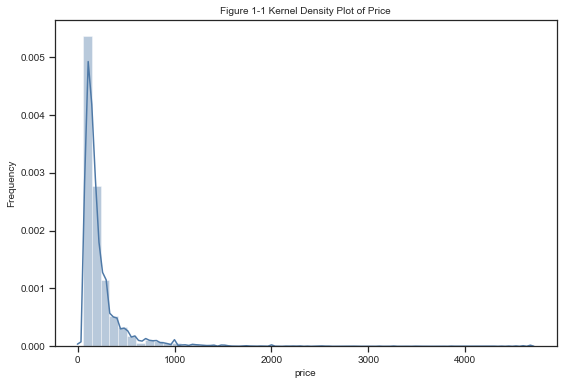

In [31]:
#check and fix price distribution
sns.distplot(train_select1['price'])
my_big_fontsize = 10
plt.xticks(fontsize = 10)
plt.yticks(fontsize = my_big_fontsize)
plt.xlabel('price', fontsize = my_big_fontsize)
plt.ylabel('Frequency', fontsize = my_big_fontsize)
plt.savefig('Figure 1-1 Kernel Density Plot of Price')
plt.title('Figure 1-1 Kernel Density Plot of Price', fontsize = my_big_fontsize)

In [32]:
print("Skewness: %f" % train_select1['price'].skew().round(3))
print("Kurtosis: %f" % train_select1['price'].kurt().round(3))

Skewness: 5.406000
Kurtosis: 48.240000


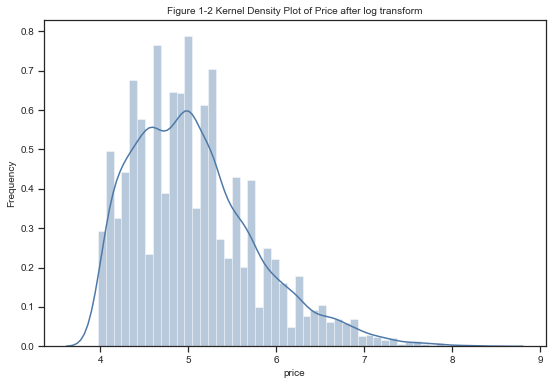

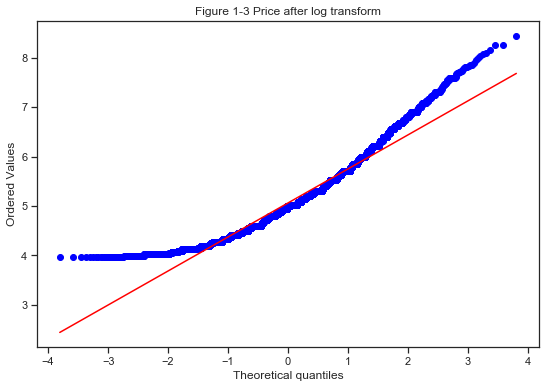

In [33]:
# plot current distribution of price after log transformation
y_train = np.log1p (train_select1['price'])

sns.distplot(y_train)
my_big_fontsize = 10
plt.xticks(fontsize = 10)
plt.yticks(fontsize = my_big_fontsize)
plt.xlabel('price', fontsize = my_big_fontsize)
plt.ylabel('Frequency', fontsize = my_big_fontsize)
plt.savefig('Figure 1-2 Kernel Density Plot of Price after log transform')
plt.title('Figure 1-2 Kernel Density Plot of Price after log transform', fontsize = my_big_fontsize)
plt.show()

res=stats.probplot(y_train,plot=plt)
plt.savefig('Figure 1-3 Price after log transform')
plt.title('Figure 1-3 Price after log transform')
plt.show()

In [34]:
train_select1['price']=y_train

In [35]:
train_select1.corr()['price'].sort_values().round(3)

calculated_host_listings_count_private_rooms   -0.237
extra_people_perc                              -0.200
reviews_per_month                              -0.065
number_of_reviews                              -0.054
calculated_host_listings_count_shared_rooms    -0.053
review_scores_value                            -0.049
number_of_reviews_ltm                          -0.047
review_scores_communication                    -0.041
review_scores_checkin                          -0.040
security_deposit_perc                          -0.039
review_scores_accuracy                         -0.037
review_scores_cleanliness                      -0.034
review_scores_location                         -0.033
review_scores_rating                           -0.033
cleaning_fee_perc                              -0.019
minimum_minimum_nights                          0.002
minimum_nights                                  0.007
minimum_nights_avg_ntm                          0.008
minimum_maximum_nights      

In [36]:
# some variable is date form, we change first review and last review to the review_gap 
train_select1['first_review']=pd.to_datetime(train_select1['first_review'])
train_select1['last_review']=pd.to_datetime(train_select1['last_review'])
train_select1['review_gap']=(train_select1['last_review']-train_select1['first_review'])
train_select1['review_gap']=train_select1['review_gap'].dt.days
# May be some null appears and we use mean to fill
train_select1['review_gap']=train_select1['review_gap'].fillna(train_select1['review_gap'].mean())

In [37]:
# some variable is date form, we change first review and last review to the review_gap 
test_select1['first_review']=pd.to_datetime(test_select1['first_review'])
test_select1['last_review']=pd.to_datetime(test_select1['last_review'])
test_select1['review_gap']=(test_select1['last_review']-test_select1['first_review'])
test_select1['review_gap']=test_select1['review_gap'].dt.days

# May be some null appears and we use mean to fill
test_select1['review_gap']=test_select1['review_gap'].fillna(test_select1['review_gap'].mean())

In [38]:
# delete first review and last review
train_select1=train_select1.drop(['host_since'], axis = 1)
test_select1=test_select1.drop(['host_since'], axis = 1)

In [39]:
train_select1=train_select1.drop(['first_review','last_review'],axis = 1)
test_select1=test_select1.drop(['first_review','last_review'],axis = 1)

In [40]:
# redefine variables
numerical = ['host_listings_count'
,'latitude'
,'longitude'
,'accommodates'
,'bathrooms'
,'bedrooms'
,'beds'
,'weekly_discount'
,'monthly_discount'
,'security_deposit_perc'
,'cleaning_fee_perc'
,'guests_included'
,'extra_people_perc'
,'minimum_nights'
,'maximum_nights'
,'minimum_minimum_nights'
,'maximum_minimum_nights'
,'minimum_maximum_nights'
,'maximum_maximum_nights'
,'minimum_nights_avg_ntm'
,'maximum_nights_avg_ntm'
,'availability_30'
,'availability_60'
,'availability_90'
,'availability_365'
,'number_of_reviews','number_of_reviews_ltm','calculated_host_listings_count','calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms', 'reviews_per_month','review_gap','host_response_rate']



text=['name','summary','space','description','neighborhood_overview','note','transit','access','interaction','house_rules','host_about']
categorical=['host_location','host_response_time','host_is_superhost','host_neighbourhood','host_verifications','host_identity_verified','street','neighbourhood',
'neighbourhood_cleansed','city','zipcode','smart_location','is_location_exact','property_type','room_type','bed_type','amenities','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','requires_license','instant_bookable','is_business_travel_ready','cancellation_policy','require_guest_profile_picture','require_guest_phone_verification']

## Location variables

In [41]:
lat=train_select1['latitude'].tolist()
lon=train_select1['longitude'].tolist()

In [42]:
# define the central coordinate of Sydney and calculate distance for eahc listing
Sydney=[-33.8548157, 151.2164539]
distance=[]
for i in range(len((train_select1['longitude']))):
    aaa=np.sqrt((lat[i]-Sydney[0])**2+(lon[i]-Sydney[1])**2)
    distance.append(aaa)
train_select1['distance']=distance

In [43]:
#change on test 
lat=test_select1['latitude'].tolist()
lon=test_select1['longitude'].tolist()

In [44]:
Sydney=[-33.8548157, 151.2164539]
distance=[]
for i in range(len((test_select1['longitude']))):
    aaa=np.sqrt((lat[i]-Sydney[0])**2+(lon[i]-Sydney[1])**2)
    distance.append(aaa)
test_select1['distance']=distance

In [45]:
dep_variable=['price']

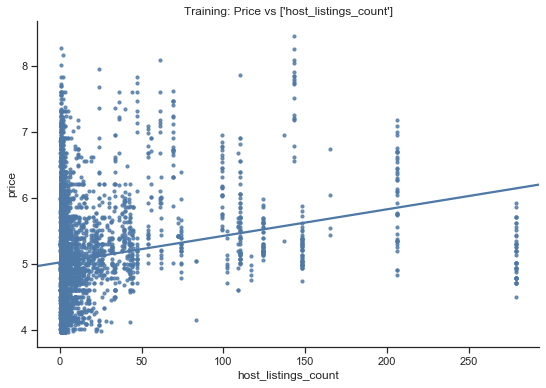

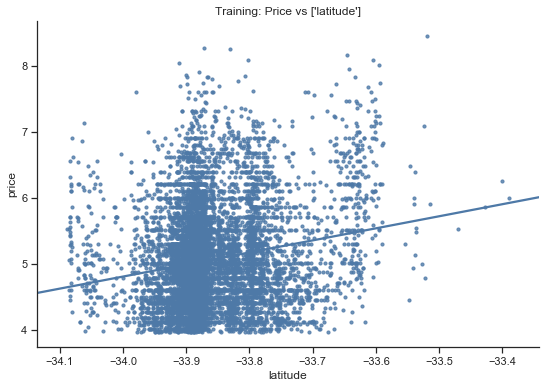

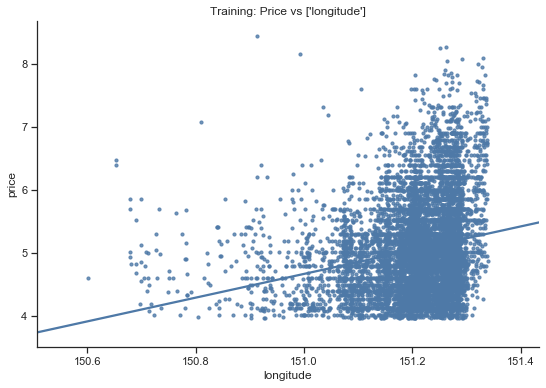

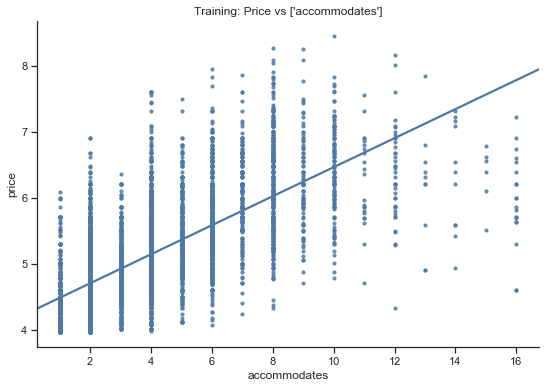

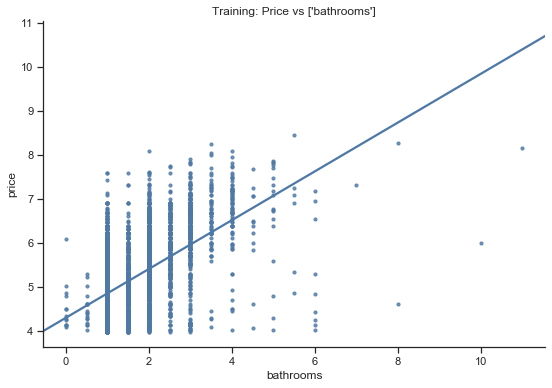

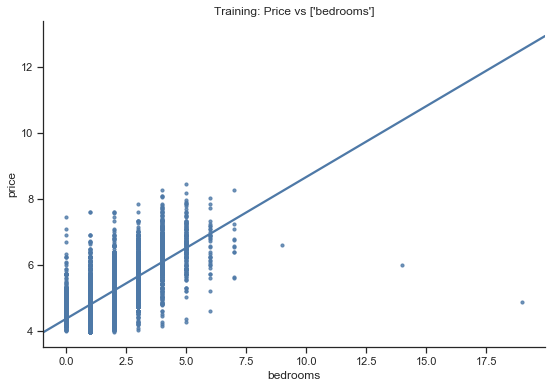

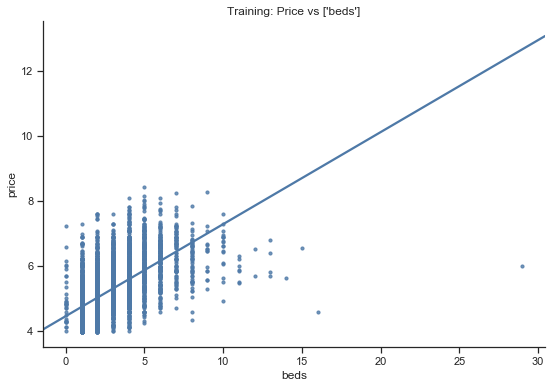

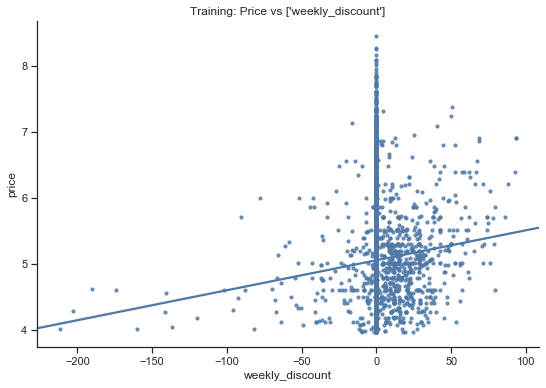

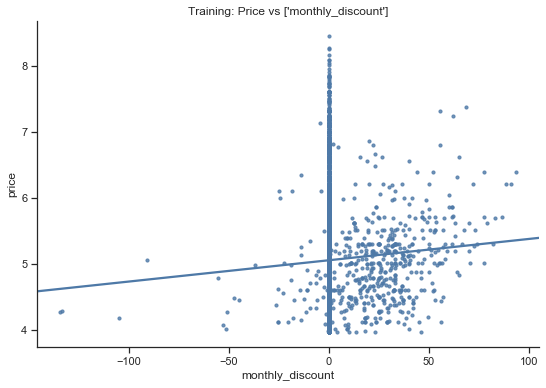

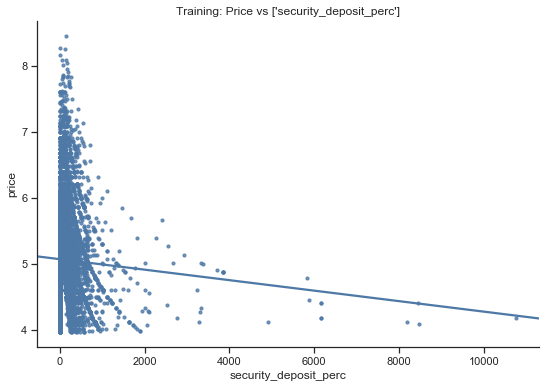

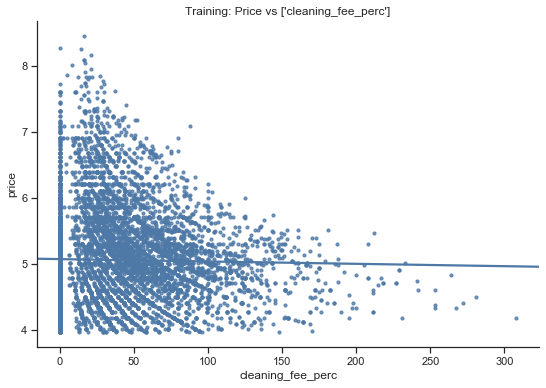

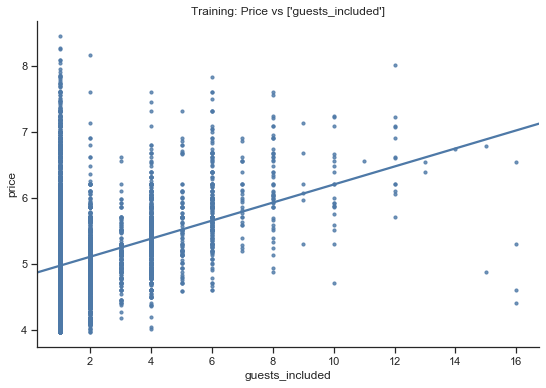

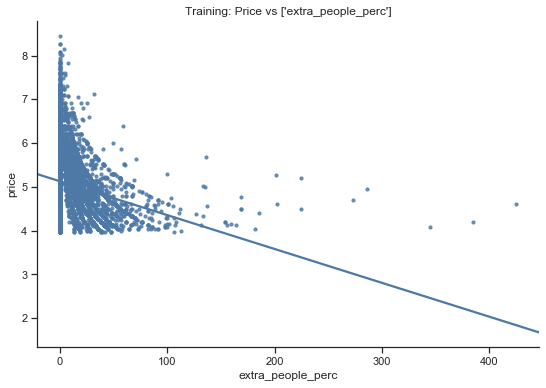

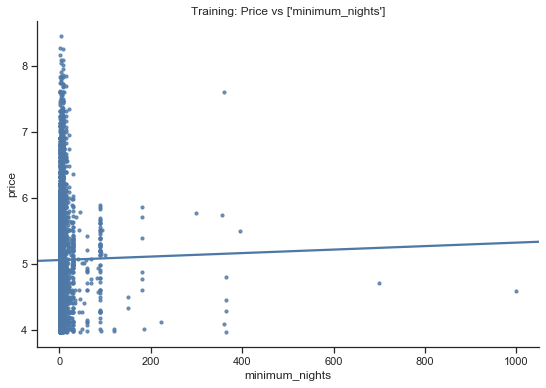

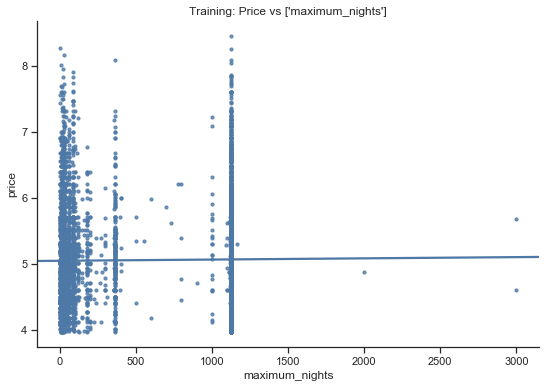

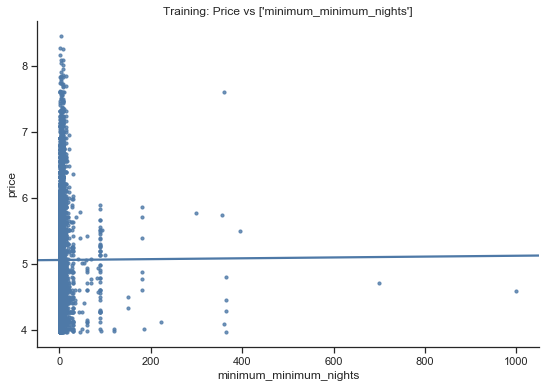

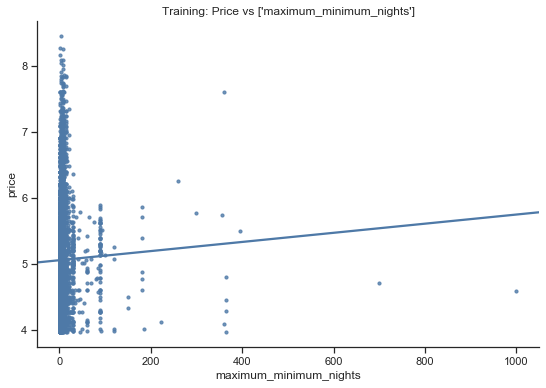

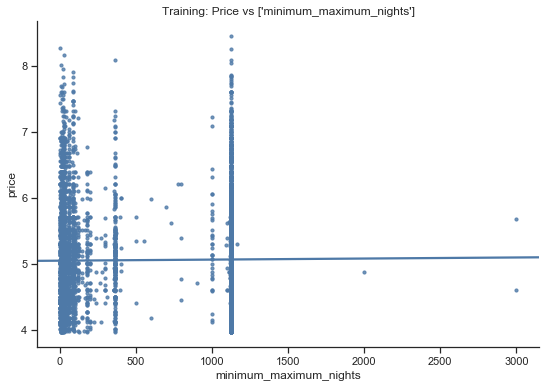

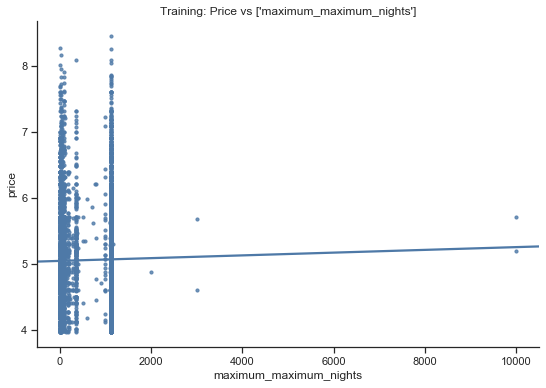

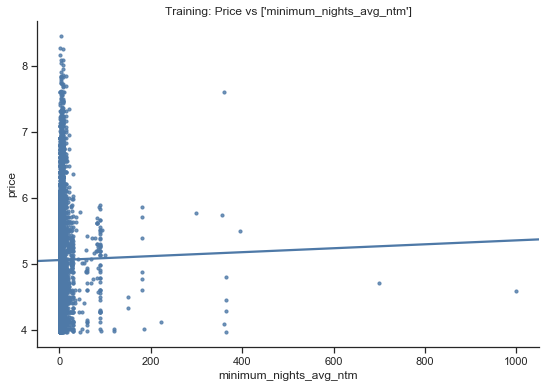

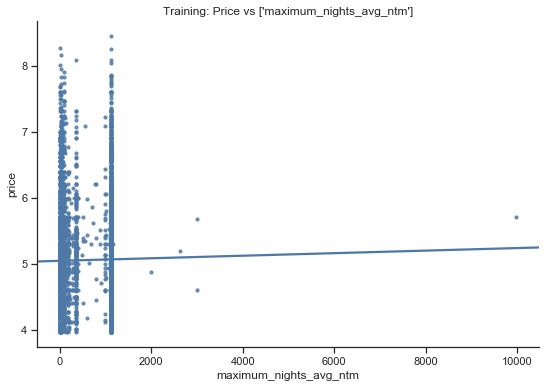

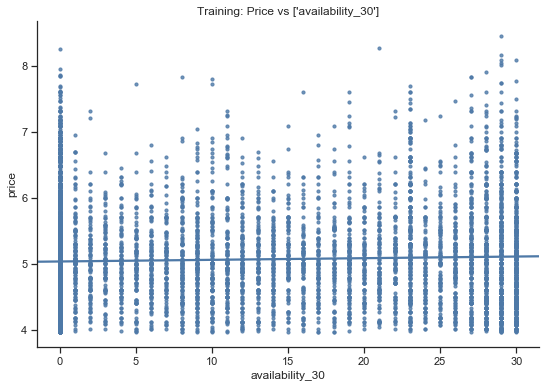

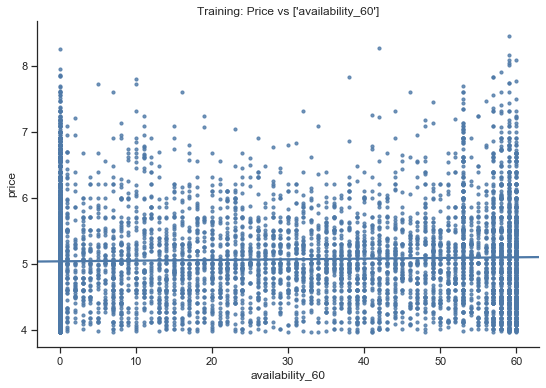

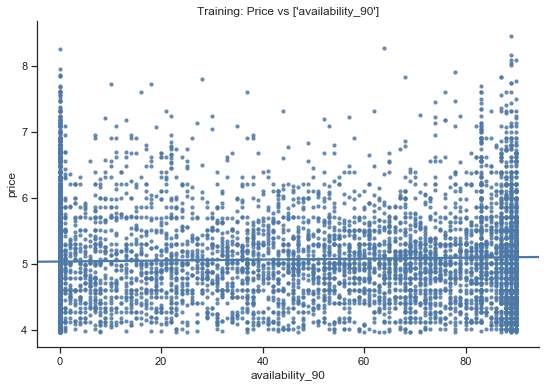

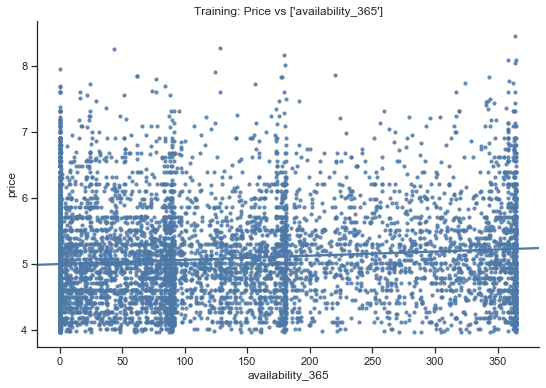

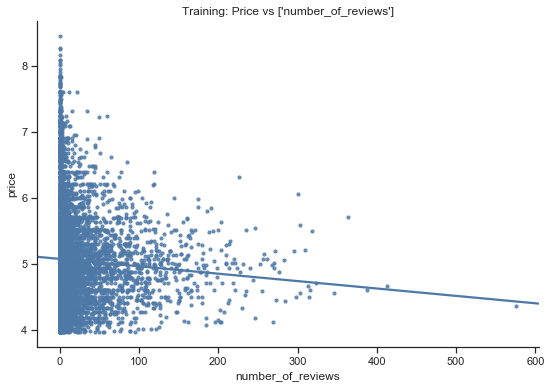

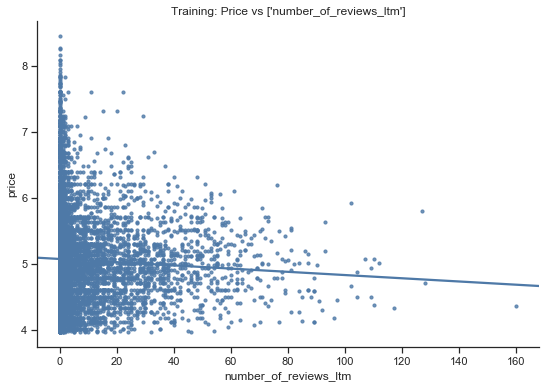

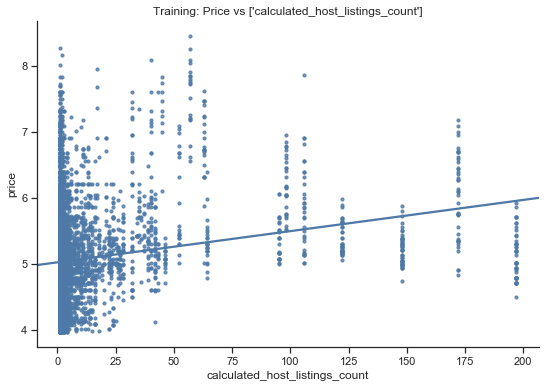

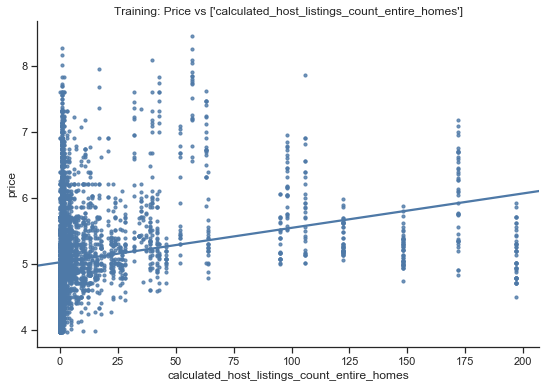

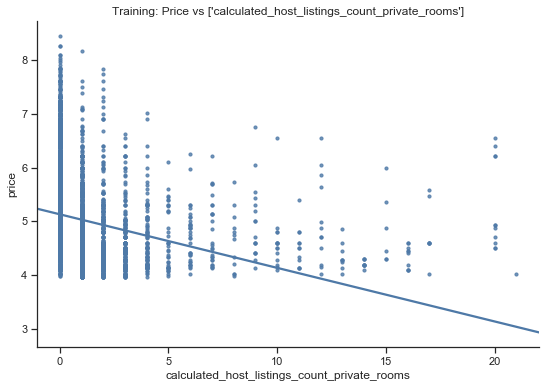

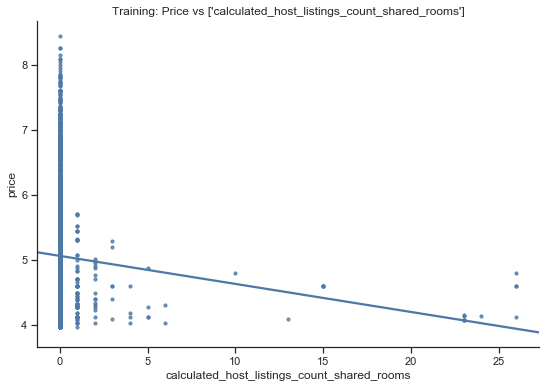

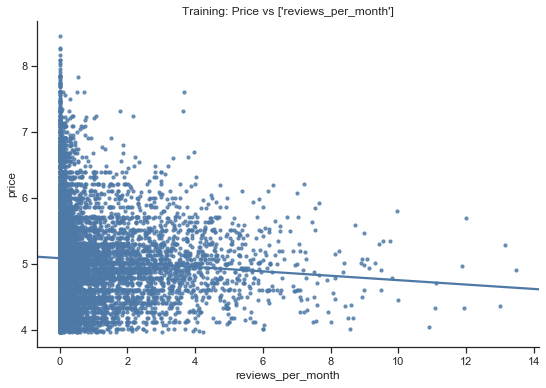

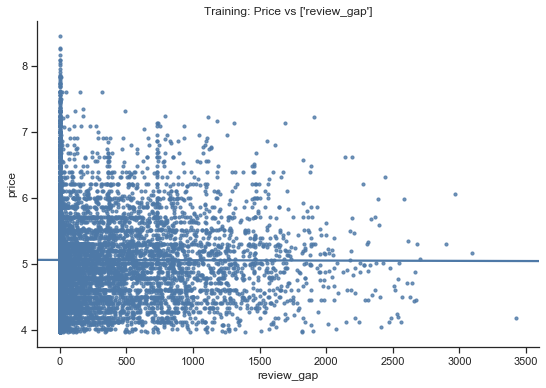

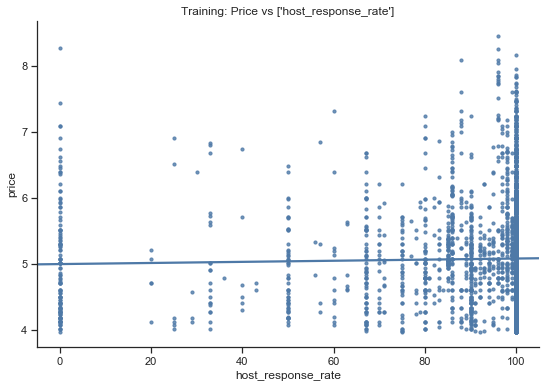

In [46]:
for i in range(len(numerical)):
    sns.regplot(train_select1[numerical[i]], (train_select1[dep_variable[0]]), scatter_kws={'s': 10}, ci=None)
    sns.despine()
    plt.title("Training: Price vs "+str([numerical[i]]))
    plt.savefig("price vs"+numerical[i])
    plt.show()

In [47]:
# correlation between numerical variables and dependent variable
correlation = numerical + dep_variable
correlation_1 = pd.DataFrame(train_select1[correlation])
correlation_1.corr()['price'].sort_values(ascending=False)

price                                           1.000000
accommodates                                    0.694417
bedrooms                                        0.674282
beds                                            0.620696
bathrooms                                       0.542539
guests_included                                 0.274022
longitude                                       0.213303
latitude                                        0.184891
calculated_host_listings_count_entire_homes     0.181092
host_listings_count                             0.173731
calculated_host_listings_count                  0.163450
availability_365                                0.108555
weekly_discount                                 0.063953
availability_30                                 0.040512
availability_90                                 0.037292
monthly_discount                                0.037059
availability_60                                 0.034140
host_response_rate             

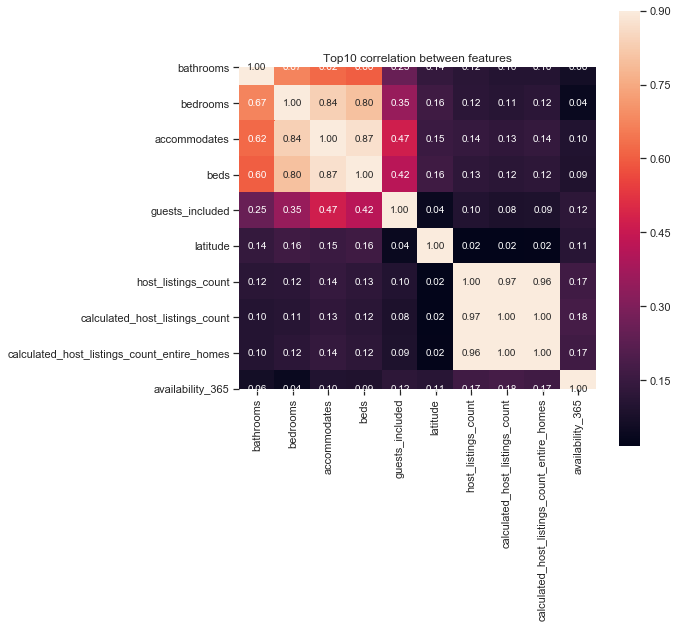

In [48]:
# plot heatmap for data correlation
corrmat=train_select1[numerical].corr()
top10_features=corrmat['bathrooms'].nlargest(n=10).index
top10=corrmat[top10_features].loc[top10_features]
plt.subplots(figsize=(8,8))
sns.heatmap(top10,vmax=0.9,square=True,annot=True,fmt=".2f")
plt.title('Top10 correlation between features')
plt.savefig('Top10 correlation between features')

In [49]:
type(train_select1)

pandas.core.frame.DataFrame

In [50]:
#delete some uncorralated numerical variables based on above table (if |corr|less than 0.1,delete)
#also drop Latitude and longitude since we have distance data
numerical = ['host_listings_count','accommodates','bathrooms','bedrooms',
             'beds','guests_included','extra_people_perc','availability_365',
             'calculated_host_listings_count','calculated_host_listings_count_entire_homes'
             ,'calculated_host_listings_count_private_rooms','distance']
text=['name','summary','space','description','neighborhood_overview','note',
      'transit','access','interaction','house_rules','host_about']
categorical=['host_location','host_response_time','host_is_superhost','host_neighbourhood',
             'host_verifications','host_identity_verified','street','neighbourhood',
             'neighbourhood_cleansed','city','zipcode','smart_location','is_location_exact',
             'property_type','room_type','bed_type','amenities','review_scores_rating','review_scores_accuracy',
             'review_scores_cleanliness','review_scores_checkin','review_scores_communication',
             'review_scores_location','review_scores_value','requires_license','instant_bookable',
             'is_business_travel_ready','cancellation_policy','require_guest_profile_picture',
             'require_guest_phone_verification']

# 3. Feature Engineering
## 3.1 Categorical data
### 3.1.1 Dummy variables

In [51]:
#change T/F values to 0/1 
train_select1['host_is_superhost']=train_select1.host_is_superhost.map({'f':0,'t':1})
train_select1['host_identity_verified']=train_select1.host_identity_verified.map({'f':0,'t':1})
train_select1['is_location_exact']=train_select1.host_identity_verified.map({'f':0,'t':1})
train_select1['requires_license']=train_select1.host_identity_verified.map({'f':0,'t':1})
train_select1['instant_bookable']=train_select1.instant_bookable.map({'f':0,'t':1})
train_select1['is_business_travel_ready']=train_select1.instant_bookable.map({'f':0,'t':1})
train_select1['require_guest_profile_picture']=train_select1.require_guest_profile_picture.map({'f':0,'t':1})
train_select1['require_guest_phone_verification']=train_select1.require_guest_phone_verification.map({'f':0,'t':1})

In [52]:
test_select1['host_is_superhost']=test_select1.host_is_superhost.map({'f':0,'t':1})
test_select1['host_identity_verified']=test_select1.host_identity_verified.map({'f':0,'t':1})
test_select1['is_location_exact']=test_select1.host_identity_verified.map({'f':0,'t':1})
test_select1['requires_license']=test_select1.host_identity_verified.map({'f':0,'t':1})
test_select1['instant_bookable']=test_select1.instant_bookable.map({'f':0,'t':1})
test_select1['is_business_travel_ready']=test_select1.instant_bookable.map({'f':0,'t':1})
test_select1['require_guest_profile_picture']=test_select1.require_guest_profile_picture.map({'f':0,'t':1})
test_select1['require_guest_phone_verification']=test_select1.require_guest_phone_verification.map({'f':0,'t':1})

### 3.1.2 Other categorical data
**Merge categorical data types**

In [53]:
# Demonstrate frequency count for each category
pd.crosstab(index=train_select1['property_type'], columns="count")

col_0,count
property_type,
Aparthotel,4
Apartment,5993
Barn,1
Bed and breakfast,54
Boat,9
Boutique hotel,46
Bungalow,51
Cabin,15
Camper/RV,3


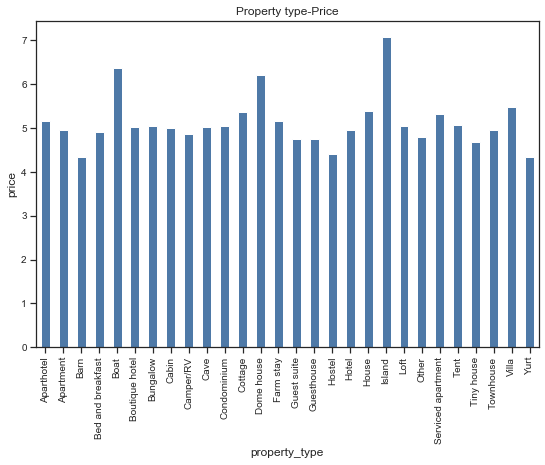

In [54]:
# visaulise with bar plot
train_select1.groupby('property_type')['price'].mean().plot.bar()
my_big_fontsize = 10
plt.xticks(fontsize = 10)
plt.yticks(fontsize = my_big_fontsize)
plt.ylabel('price')
plt.savefig('Property type-Price')
plt.title('Property type-Price')
plt.show()

In [55]:
# merge data type 
train_select1['property_type'] = np.where(train_select1['property_type'].str.contains('House'), "House", (np.where(train_select1['property_type'].str.contains('Apartment'), "Apartment", (np.where(train_select1['property_type'].str.contains('Townhouse'), "Townhouse", "Other")))))

In [56]:
test_select1['property_type'] = np.where(test_select1['property_type'].str.contains('House'), "House", (np.where(test_select1['property_type'].str.contains('Apartment'), "Apartment", (np.where(test_select1['property_type'].str.contains('Townhouse'), "Townhouse", "Other")))))

In [57]:
# Count frequency of different categories after sorting to smaller number of categories
pd.crosstab(index=train_select1["property_type"], columns="count")

col_0,count
property_type,
Apartment,5993
House,2488
Other,936
Townhouse,421


In [58]:
pd.crosstab(index=test_select1["property_type"], columns="count")

col_0,count
property_type,
Apartment,13873
House,5833
Other,2249
Townhouse,1002


In [59]:
pd.crosstab(index=train_select1["property_type"], columns="count")

col_0,count
property_type,
Apartment,5993
House,2488
Other,936
Townhouse,421


In [60]:
train_select1['bed_type'] = np.where(train_select1['bed_type'].str.contains('Bed'), "Bed" , "Other")

In [61]:
test_select1['bed_type'] = np.where(test_select1['bed_type'].str.contains('Bed'), "Bed" , "Other")

In [62]:
pd.crosstab(index=train_select1["bed_type"], columns="count")

col_0,count
bed_type,
Bed,9792
Other,46


In [63]:
train_select1['cancellation_policy'] = np.where(train_select1['cancellation_policy'].str.contains('flexible'), "flexible", (np.where(train_select1['cancellation_policy'].str.contains('luxury'), "luxury", (np.where(train_select1['cancellation_policy'].str.contains('strict'), "strict", "moderate")))))

In [64]:
pd.crosstab(index=train_select1["cancellation_policy"], columns="count")

col_0,count
cancellation_policy,
flexible,3275
luxury,2
moderate,2277
strict,4284


In [65]:
test_select1['cancellation_policy'] = np.where(test_select1['cancellation_policy'].str.contains('flexible'), "flexible", (np.where(test_select1['cancellation_policy'].str.contains('luxury'), "luxury", (np.where(test_select1['cancellation_policy'].str.contains('strict'), "strict", "moderate")))))

In [66]:
pd.crosstab(index=test_select1["cancellation_policy"], columns="count")

col_0,count
cancellation_policy,
flexible,7621
luxury,6
moderate,5376
strict,9954


In [67]:
#Reviews_score_rating
# change the scores from 20-100 to 2-10 to be comparable with other review score
max_100_features='review_scores_rating'
train_select1[max_100_features]=train_select1[max_100_features]/10
train_select1.describe()

,host_response_rate,host_is_superhost,host_listings_count,host_identity_verified,latitude,longitude,is_location_exact,accommodates,bathrooms,bedrooms,...,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,price,review_gap,distance
count,5272.000000,9838.000000,9838.000000,9838.000000,9838.000000,9838.000000,0.0,9838.000000,9838.000000,9838.000000,...,9838.000000,9838.000000,9838.000000,9838.000000,9838.000000,9838.000000,9838.000000,9838.000000,9838.000000,9838.000000
mean,94.229894,0.150030,9.226367,0.394592,-33.862776,151.208011,NaN,3.601240,1.374314,1.651352,...,0.005082,0.005896,7.537304,6.808091,0.678797,0.050417,0.804021,5.062752,282.856678,0.082117
std,17.756833,0.357119,30.638615,0.488788,0.071810,0.080174,NaN,2.241736,0.692973,1.110914,...,0.071113,0.076559,24.541786,24.617591,1.686192,0.872879,1.388668,0.707969,450.242209,0.070535
min,0.000000,0.000000,0.000000,0.000000,-34.088290,150.601470,NaN,1.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.970292,0.000000,0.003286
25%,100.000000,0.000000,1.000000,0.000000,-33.896860,151.184900,NaN,2.000000,1.000000,1.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,4.499810,0.000000,0.037144
50%,100.000000,0.000000,1.000000,0.000000,-33.881150,151.216700,NaN,3.000000,1.000000,1.000000,...,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.160000,4.990433,38.000000,0.064133
75%,100.000000,0.000000,3.000000,1.000000,-33.832150,151.262497,NaN,4.000000,2.000000,2.000000,...,0.000000,0.000000,2.000000,1.000000,1.000000,0.000000,1.000000,5.468060,405.000000,0.094837
max,100.000000,1.000000,279.000000,1.000000,-33.389730,151.339810,NaN,16.000000,11.000000,19.000000,...,1.000000,1.000000,197.000000,197.000000,21.000000,26.000000,13.490000,8.446127,3427.000000,0.615024


## 3.2 Numerical data
**Numerical to categorical**

In [68]:
# define scoring function
def level (val,prefix=""):
    if val>= 8:
        return prefix + "_Good"
    elif  val>=5:
        return prefix + "_Fair"
    elif val>=2:
        return prefix + "_Poor"
    else:
        return prefix + "_No_review"

In [69]:
review_scores = ['review_scores_rating']

In [70]:
for feature in review_scores:
    train_select1[feature]=train_select1[feature].apply(level, prefix = feature)

In [71]:
pd.crosstab(index=train_select1["review_scores_rating"], columns="count")

col_0,count
review_scores_rating,
review_scores_rating_Fair,216
review_scores_rating_Good,6616
review_scores_rating_No_review,2950
review_scores_rating_Poor,56


In [72]:
#do same on test
max_100_features='review_scores_rating'
test_select1[max_100_features]=test_select1[max_100_features]/10
test_select1.describe()

,id,host_response_rate,host_is_superhost,host_listings_count,host_identity_verified,latitude,longitude,is_location_exact,accommodates,bathrooms,...,is_business_travel_ready,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,review_gap,distance
count,22957.000000,12344.000000,22957.000000,22957.000000,22957.000000,22957.000000,22957.000000,0.0,22957.000000,22957.000000,...,0.0,22957.000000,22957.000000,22957.000000,22957.000000,22957.000000,22957.000000,22957.000000,22957.000000,22957.000000
mean,11478.000000,94.164209,0.153461,9.660539,0.395130,-33.861600,151.207972,NaN,3.601864,1.369604,...,NaN,0.005663,0.006882,7.843882,7.127020,0.664503,0.052359,0.811778,290.608311,0.082222
std,6627.259401,18.113763,0.360439,33.116388,0.488889,0.072294,0.080571,NaN,2.235104,0.716680,...,NaN,0.075040,0.082676,25.869215,25.951898,1.630217,0.889305,1.371959,457.775001,0.071240
min,0.000000,0.000000,0.000000,0.000000,0.000000,-34.135210,150.605110,NaN,1.000000,0.000000,...,NaN,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003081
25%,5739.000000,100.000000,0.000000,1.000000,0.000000,-33.896770,151.184150,NaN,2.000000,1.000000,...,NaN,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037059
50%,11478.000000,100.000000,0.000000,1.000000,0.000000,-33.881090,151.216980,NaN,3.000000,1.000000,...,NaN,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.170000,43.000000,0.064441
75%,17217.000000,100.000000,0.000000,3.000000,1.000000,-33.831160,151.262500,NaN,4.000000,2.000000,...,NaN,0.000000,0.000000,2.000000,1.000000,1.000000,0.000000,1.000000,422.000000,0.094582
max,22956.000000,100.000000,1.000000,438.000000,1.000000,-33.395750,151.339870,NaN,16.000000,18.000000,...,NaN,1.000000,1.000000,197.000000,197.000000,21.000000,26.000000,13.600000,3077.000000,0.611367


In [73]:
review_scores = ['review_scores_rating']

In [74]:
for feature in review_scores:
    test_select1[feature]=test_select1[feature].apply(level, prefix = feature)

In [75]:
pd.crosstab(index=test_select1["review_scores_rating"], columns="count")

col_0,count
review_scores_rating,
review_scores_rating_Fair,536
review_scores_rating_Good,15561
review_scores_rating_No_review,6748
review_scores_rating_Poor,112


## 3.3 Text based variables
### 'Summary'

In [76]:
#split summary into words
# define text processing function
def process_text(text) :
    Tokenizer = TweetTokenizer()
    tokenized = Tokenizer.tokenize(text)
    punctuation = list(string.punctuation)
    punctuation.remove('!')
    tokenized_no_punctuation=[word.lower() for word in tokenized if word not in punctuation]
    tokenized_no_stopwords=[word for word in tokenized_no_punctuation if word not in stopwords.words('english')]
    tokens = [PorterStemmer().stem(word) for word in tokenized_no_stopwords if word != '️']
    return tokens
summary=train_select1["summary"]
sumtoken=summary.apply(process_text)
sumtoken.head()

0    [2, room, new, apart, stay, privat, garden, sh...
1    [beachfront, balconi, next, cafe, restaur, sui...
2    [excel, locat, !, close, superb, bar, cafe, pa...
3    [typic, inner, west, sydney, share, hous, live...
4    [2, bedroom, loft, apart, small, complex, well...
Name: summary, dtype: object

In [77]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


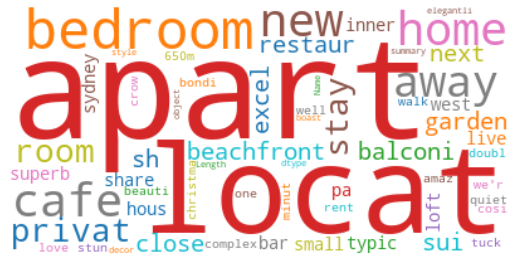

In [78]:
# Plot word cloud for summary column
from wordcloud import WordCloud
fig, ax = plt.subplots()
wordcloud = WordCloud(background_color="white", colormap='tab10', max_words=200).generate(str(sumtoken))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [79]:
fdist = nltk.FreqDist()
for words in sumtoken:
    for word in words:
        fdist[word] += 1

print(f'Number of unique tokens: {len(fdist)}')

Number of unique tokens: 11779


In [80]:
fdist.most_common()[:100]

[('walk', 6600),
 ('apart', 5936),
 ('beach', 5828),
 ('bedroom', 4615),
 ('locat', 4404),
 ('sydney', 4338),
 ('minut', 4323),
 ('room', 3232),
 ('citi', 3074),
 ('shop', 3017),
 ('!', 3011),
 ('2', 2899),
 ('park', 2893),
 ('min', 2848),
 ('restaur', 2832),
 ('bondi', 2698),
 ('home', 2628),
 ('bed', 2520),
 ('hous', 2445),
 ('close', 2442),
 ('cafe', 2423),
 ('station', 2346),
 ('kitchen', 2268),
 ('view', 2165),
 ('live', 2164),
 ('bathroom', 2109),
 ('bu', 2080),
 ('train', 2021),
 ('place', 1992),
 ('beauti', 1979),
 ('area', 1961),
 ('cbd', 1917),
 ('larg', 1846),
 ('modern', 1770),
 ('one', 1734),
 ('privat', 1732),
 ('balconi', 1660),
 ('away', 1655),
 ('street', 1620),
 ('perfect', 1617),
 ('enjoy', 1595),
 ('harbour', 1593),
 ('5', 1553),
 ('famili', 1497),
 ('spaciou', 1490),
 ('great', 1466),
 ('quiet', 1433),
 ('two', 1420),
 ('stay', 1381),
 ('transport', 1378),
 ('1', 1347),
 ('access', 1327),
 ('new', 1313),
 ('space', 1298),
 ('10', 1289),
 ('comfort', 1283),
 ('love'

In [81]:
positive=['beach','sydney','citi','shop','park','restau','bondi','close','cafe','station','kitchen',
          'view','train','beauti','cbd','larg','modern','privat','perfect','enjoy','harbour',
          'spaciou','great','quiet','new','comfort','love','central','conveni','centr',
          'renov','relax','easi','free','best','light','clean','bar','garden','pool']


In [82]:
a=[]
count=0
#sumtoken=sumtoken.tolist()
for i in range(len(sumtoken)):
    for j in sumtoken[i]:
        if j in positive:
            count+=1
    a.append(count)
    count=0
#print(a)
train_select1['summary_score']=a

In [83]:
train_select1.head()

,name,summary,space,description,neighborhood_overview,notes,transit,access,interaction,house_rules,...,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,price,review_gap,distance,summary_score
0,Private room + garden 2mins walk to everywhere.,"2 rooms new apartment, your stay with private ...","2 bedroom apartment, you got one of the room a...","2 rooms new apartment, your stay with private ...",NA,NA,NA,NA,NA,Keep quiet after 9pm No BBQ No party No extra ...,...,0,7,5,2,0,0.00,4.077537,0,0.184193,4
1,"On the Beachfront, next to cafes and restaurants.",Beachfront balcony and next to cafes and resta...,"Happy to accommodate your requests, as best we...",Beachfront balcony and next to cafes and resta...,"Comfortable, relaxed, beachy with ample cafes ...",NA,The bus stop is within 50m of the front door. ...,NA,NA,NA,...,0,2,1,1,0,0.15,4.836282,217,0.126709,5
2,Room in Camperdown,"Excellent location! Close to superb bars, cafe...",NA,"Excellent location! Close to superb bars, cafe...",NA,NA,NA,NA,NA,NA,...,0,1,0,1,0,0.00,4.605170,0,0.053924,6
3,Beautiful room in summer hill,"A Typical inner west sydney share house, you w...","Living room, out back balcony, kitchen, bathro...","A Typical inner west sydney share house, you w...","Summer hill, is a gorgeous and quiet inner we...","Make yourself at home, enjoy a typical inner w...","Train is 5 minutes walking distance from house,",NA,"I will be away in Europe, so won’t be able to ...",NA,...,0,1,0,1,0,0.00,4.605170,0,0.089369,6
4,2 Bedroom Apartment in Kensington.,2 Bedroom Loft Apartment in a small complex. W...,NA,2 Bedroom Loft Apartment in a small complex. W...,NA,NA,NA,NA,NA,NA,...,0,1,1,0,0,0.05,4.836282,0,0.049777,4


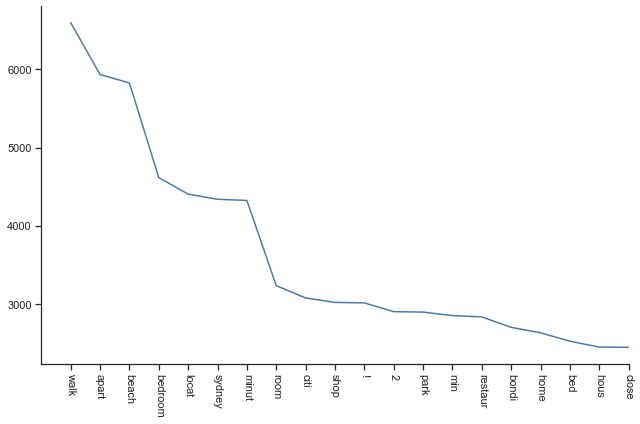

In [84]:
fig, ax = plt.subplots()

y = pd.Series(dict(fdist.most_common()[:20]))
y = y.sort_values(ascending=False)

y.plot()

indexes = np.arange(0, len(y)) # we will place ticks for every word
ax.set_xticks(indexes)
ax.set_xticklabels(y.index, rotation='-90')
ax.set_xlim(-1)

plt.tight_layout()

sns.despine()
plt.show()

In [85]:
# split words in summary column
summary=test_select1["summary"]
sumtoken=summary.apply(process_text)
sumtoken.head()

0    [spaciou, one, bed, apart, big, balconi, half,...
1    [world, famou, bondi, beach, doorstep, wonder,...
2    [cosi, 2, bedroom, apart, insid, brand, new, a...
3    [second, bedroom, tranquil, sydney, cbd, ensui...
4    [apart, tuck, away, tree, .., total, tranquil,...
Name: summary, dtype: object

In [86]:
fdist = nltk.FreqDist()
for words in sumtoken:
    for word in words:
        fdist[word] += 1

In [87]:
#summary is changed to summary score 
a=[]
count=0
#sumtoken=sumtoken.tolist()
for i in range(len(sumtoken)):
    for j in sumtoken[i]:
        if j in positive:
            count+=1
    a.append(count)
    count=0
#print(a)
test_select1['summary_score']=a

In [88]:
test_select1.head()

,id,name,summary,space,description,neighborhood_overview,notes,transit,access,interaction,...,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,review_gap,distance,summary_score
0,0,Spacious 1 bed apt with big balcony in waterloo,spacious one bed apartment with a big balcony ...,There is a east village wilson parking availab...,spacious one bed apartment with a big balcony ...,Close to east village shoppibg center 200m away,Wifi will be avalible at the end of Sepnationa...,2 mins walking distance to east village shoppi...,We have a public small garden on level5☺,(Phone number hidden by Airbnb) We are help to...,...,0,0,3,3,0,0,5.07,177,0.048235,12
1,1,"Location, Location, moments to Bondi Beach",World famous Bondi Beach at your doorstep. Th...,Our place was a hotel in its previous life. I...,World famous Bondi Beach at your doorstep. Th...,Oh my lord ... its Bondi Beach - the area is a...,"This property is in the heart of Bondi Beach, ...","There is good public transport with buses, and...",The entire room/unit is yours and you are not ...,I am available to help with questions or issue...,...,0,0,2,2,0,0,1.99,626,0.068642,8
2,2,Cosy room in a brand new design apartment.,"Cosy 2 bedroom apartment , inside a brand new ...","Private bedroom,and private bathroom. Communna...","Cosy 2 bedroom apartment , inside a brand new ...","Waterloo is a vibrant new growing area ,locate...",NA,NA,NA,"Will be there once a while,mostly working,but ...",...,0,0,1,0,1,0,1.73,188,0.046384,1
3,3,Tranquility in Sydney 2,This is a second bedroom in Tranquility in Syd...,The room is located on the first level and aff...,This is a second bedroom in Tranquility in Syd...,As in main listing for Tranquility in Sydney CBD,As in main listing for Tranquility in Sydney CBD,"Public, private transport, taxi, walking the area","Access to ground floor - kitchen, lounge, din...",Available to assist with queries or help.,...,0,0,2,0,2,0,0.10,45,0.012828,3
4,4,Tree House Apartment (2 - 4 pers),This apartment is tucked away in the trees.. T...,Recently refurbished 2 bedroom apartment with ...,This apartment is tucked away in the trees.. T...,The local area is a great place to unwind and ...,The property is accessed by stairs so guests s...,Having a car is very helpful while staying her...,Access to the Apartment is via private deck ov...,Guests have complete privacy however we are av...,...,0,0,2,2,0,0,0.21,336,0.225057,9


In [89]:
#delete some category varibles 
numerical = ['host_listings_count','accommodates','bathrooms','bedrooms',
             'beds','guests_included','extra_people_perc','availability_365',
             'calculated_host_listings_count','calculated_host_listings_count_entire_homes'
             ,'calculated_host_listings_count_private_rooms','distance','summary_score']
categorical=['host_response_time','host_is_superhost',
            'host_identity_verified',
             'property_type','room_type','bed_type',
             'review_scores_rating','instant_bookable','cancellation_policy','require_guest_profile_picture',
             'require_guest_phone_verification']
text=['name','space','transit','access','interaction','house_rules','host_about']
word = ['host_verifications','amenities']

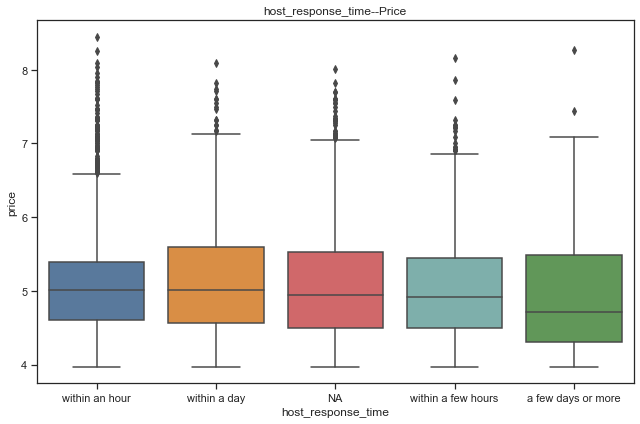

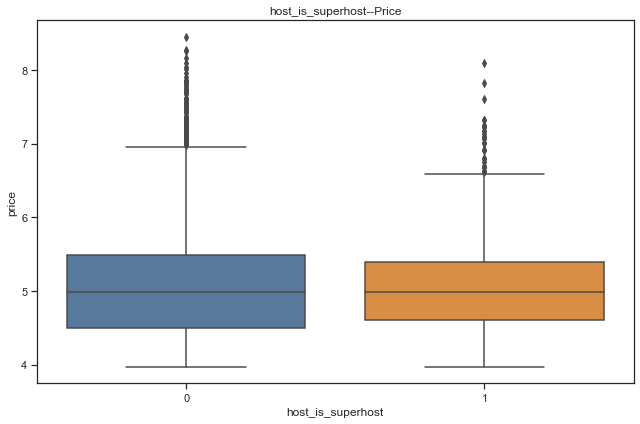

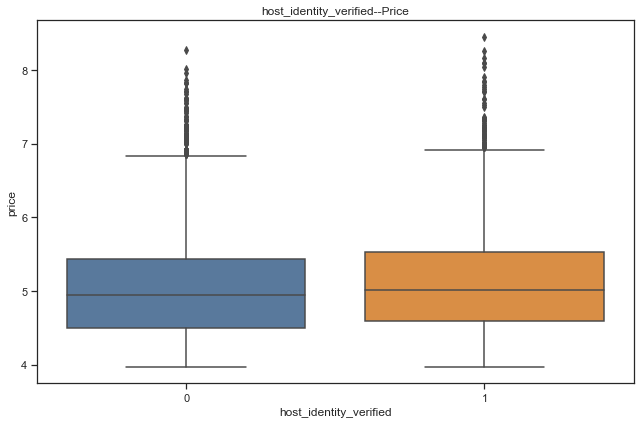

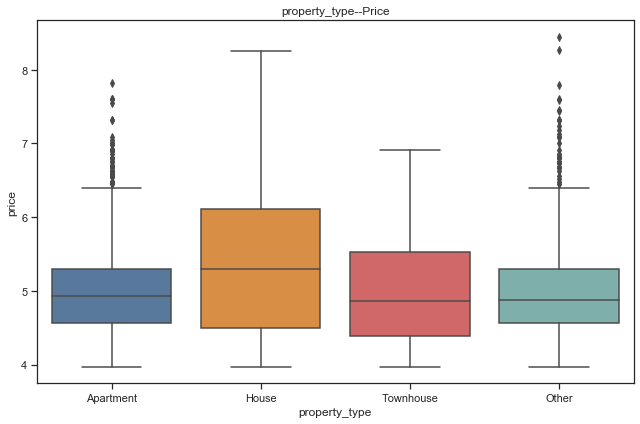

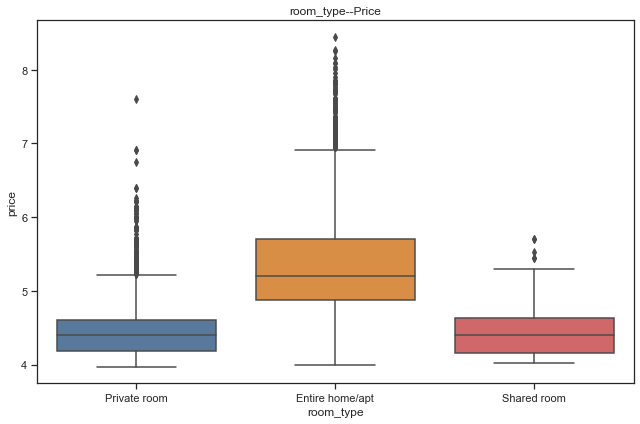

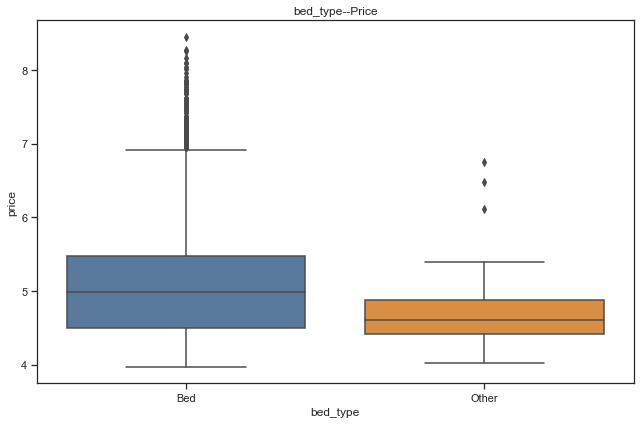

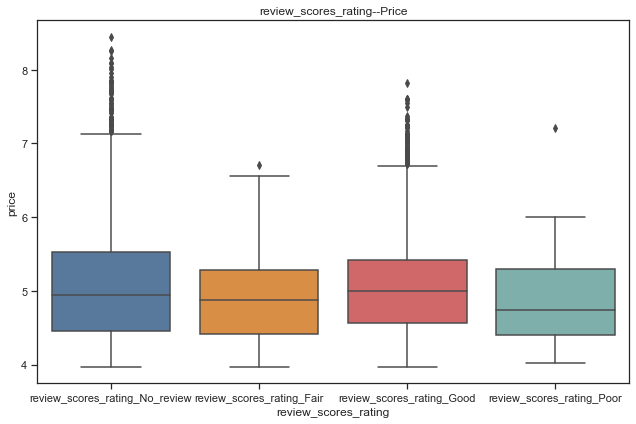

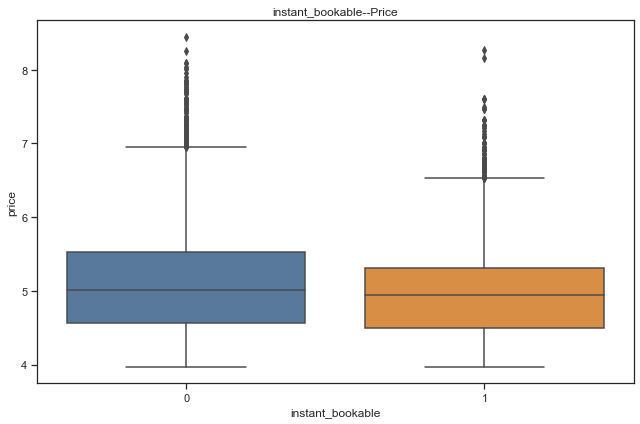

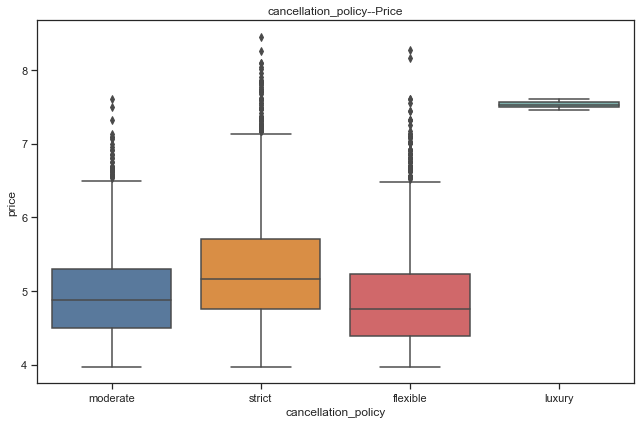

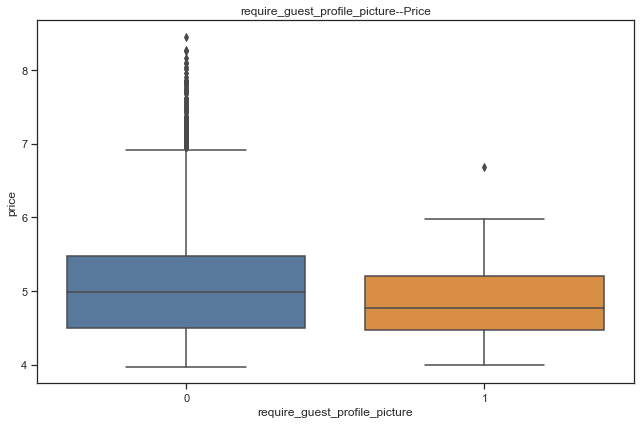

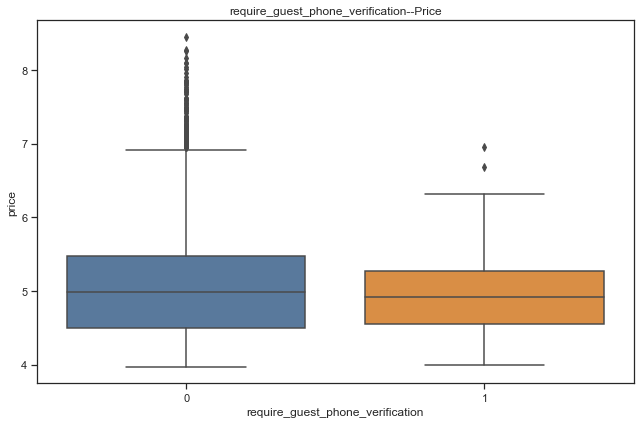

In [90]:
#check category variables and check box chart to see corralation
for i in categorical:
    sns.boxplot(x=i,y=train_select1['price'],data=train_select1[categorical])
    plt.savefig(i+'Price')
    plt.title(i+'--Price')
    plt.tight_layout()
    plt.show()

In [91]:
#based on the Box plots, some variables can be deleted: host_response_time, host_is_superhost , host_identity_verified,
#instant_bookable,require_guest_phone_verification

categorical=['property_type','room_type','bed_type',
             'review_scores_rating','instant_bookable',
             'cancellation_policy','require_guest_profile_picture']

word = ['host_verifications','amenities']

### Change words variables to numerical data
#### 'amenities'  'host_verifications'

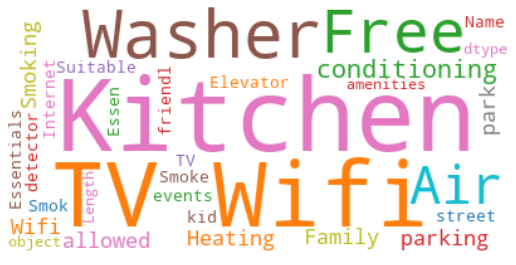

In [92]:
# plot word cloud for amenities
fig, ax = plt.subplots()
wordcloud = WordCloud(background_color="white", colormap='tab10', max_words=200).generate(str(train_select1['amenities']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

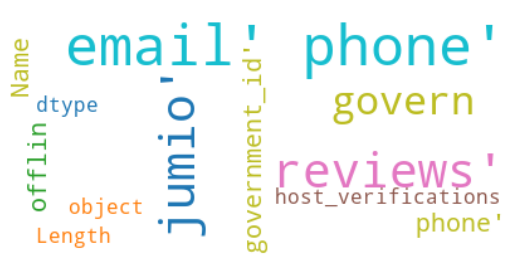

In [93]:
# plot word cloud for host verifications
fig, ax = plt.subplots()
wordcloud = WordCloud(background_color="white", colormap='tab10', max_words=200).generate(str(train_select1['host_verifications']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [94]:
# count number of words for each listing
test_select1['amenities'] = test_select1['amenities'].apply(lambda x :  x.count(',')+1)
test_select1['amenities']

0        27
1        34
2        14
3        11
4        19
         ..
22952    23
22953    25
22954    11
22955    21
22956    39
Name: amenities, Length: 22957, dtype: int64

In [95]:
train_select1['amenities'] = train_select1['amenities'].apply(lambda x :  x.count(',')+1)
train_select1['amenities']

0       24
1       18
2        6
3        9
4       10
        ..
9833    33
9834    37
9835     9
9836     9
9837    18
Name: amenities, Length: 9838, dtype: int64

In [96]:
test_select1['host_verifications'] = test_select1['host_verifications'].apply(lambda x :  x.count(',')+1)
test_select1['host_verifications']

0        7
1        7
2        5
3        3
4        5
        ..
22952    6
22953    3
22954    6
22955    5
22956    5
Name: host_verifications, Length: 22957, dtype: int64

In [97]:
train_select1['host_verifications'] = train_select1['host_verifications'].apply(lambda x :  x.count(',')+1)
train_select1['host_verifications']

0       8
1       6
2       2
3       5
4       3
       ..
9833    5
9834    5
9835    2
9836    4
9837    1
Name: host_verifications, Length: 9838, dtype: int64

In [98]:
# redefine predictors
numerical = ['host_listings_count','accommodates','bathrooms','bedrooms',
             'beds','guests_included','extra_people_perc','availability_365',
             'calculated_host_listings_count','calculated_host_listings_count_entire_homes'
             ,'calculated_host_listings_count_private_rooms','distance','summary_score',
             'amenities','host_verifications']
categorical=['property_type','room_type','bed_type',
             'review_scores_rating','instant_bookable',
             'cancellation_policy','require_guest_profile_picture']


In [99]:
train_new=train_select1[numerical+categorical+dep_variable]
test_new=test_select1[numerical+categorical]

#### Get dummy for newly formed categorical variables

In [102]:
# get dummy value for categorical features
train_dummy = pd.get_dummies(train_new, drop_first = True)
test_dummy = pd.get_dummies(test_new, drop_first = True)
train_dummy.head()

,host_listings_count,accommodates,bathrooms,bedrooms,beds,guests_included,extra_people_perc,availability_365,calculated_host_listings_count,calculated_host_listings_count_entire_homes,...,property_type_Townhouse,room_type_Private room,room_type_Shared room,bed_type_Other,review_scores_rating_review_scores_rating_Good,review_scores_rating_review_scores_rating_No_review,review_scores_rating_review_scores_rating_Poor,cancellation_policy_luxury,cancellation_policy_moderate,cancellation_policy_strict
0,9.0,2,1.0,1.0,1.0,1,52.0,326,7,5,...,0,1,0,0,0,1,0,0,1,0
1,1.0,3,1.0,1.0,2.0,2,8.0,311,2,1,...,0,0,0,0,0,0,0,0,0,1
2,1.0,2,1.0,1.0,1.0,1,0.0,0,1,0,...,0,1,0,0,0,1,0,0,0,0
3,1.0,2,1.0,1.0,1.0,1,0.0,179,1,0,...,0,1,0,0,0,1,0,0,0,1
4,1.0,4,1.5,2.0,2.0,1,0.0,0,1,1,...,0,0,0,0,1,0,0,0,0,0


In [103]:
train_dummy['summary_score']

0        4
1        5
2        6
3        6
4        4
        ..
9833    10
9834    11
9835     0
9836     5
9837     9
Name: summary_score, Length: 9838, dtype: int64

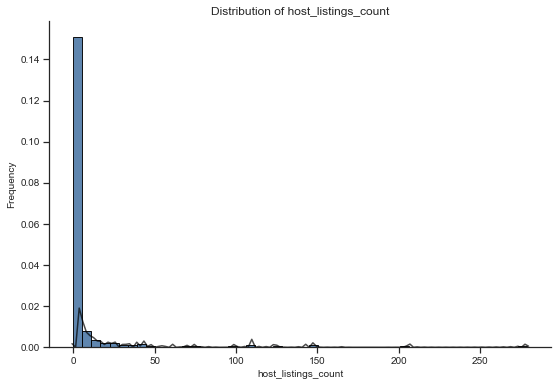

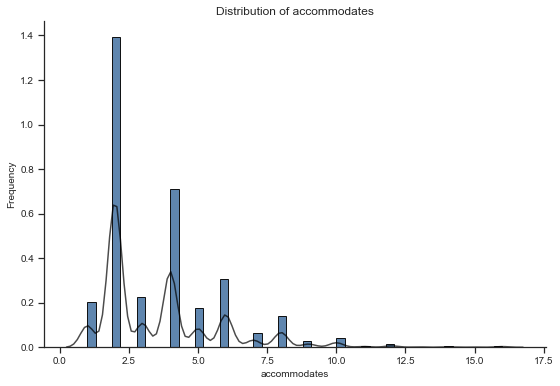

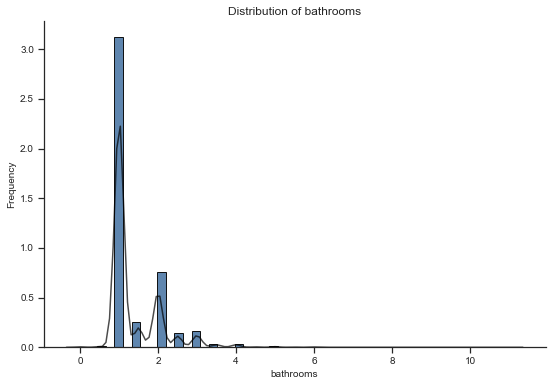

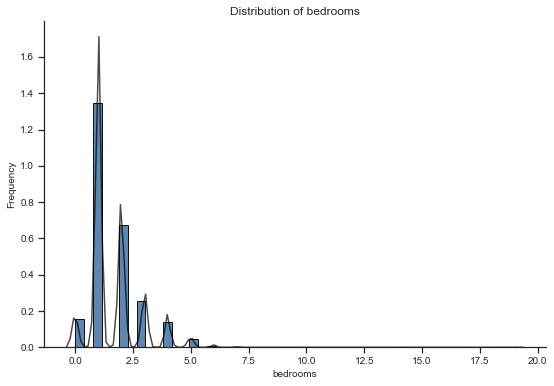

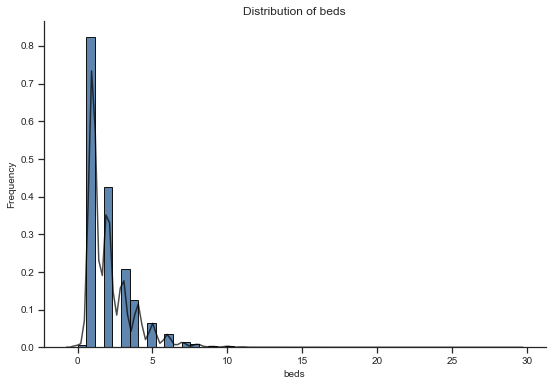

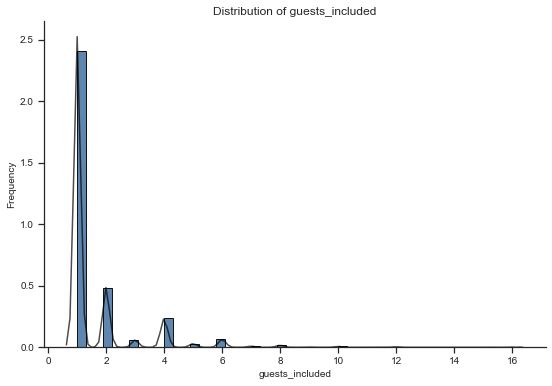

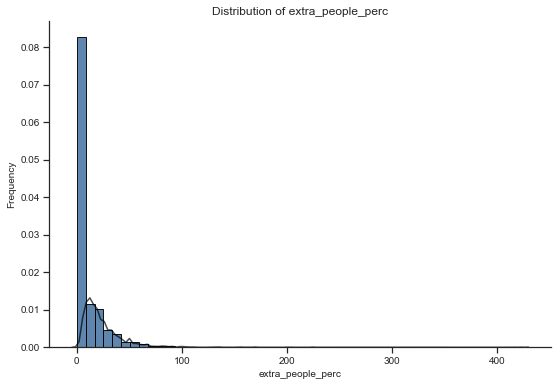

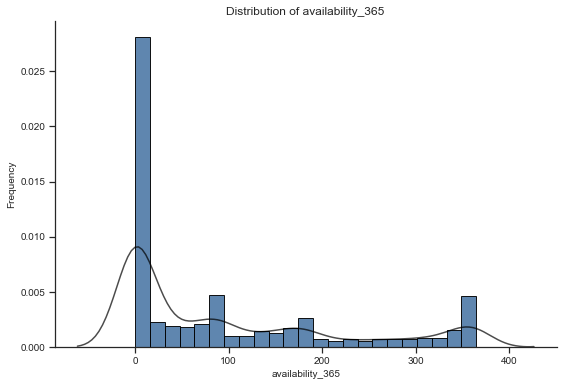

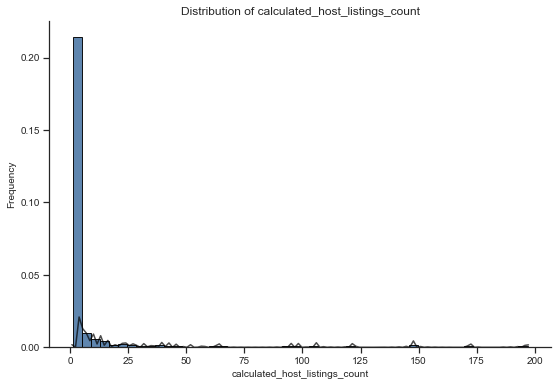

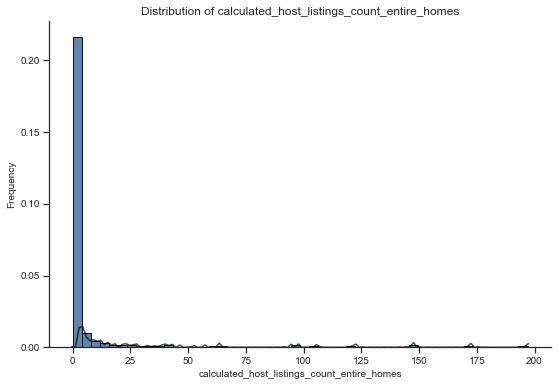

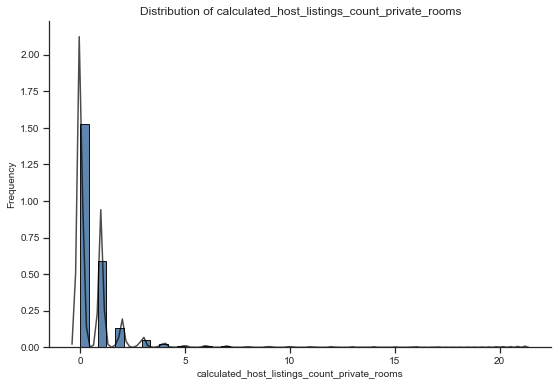

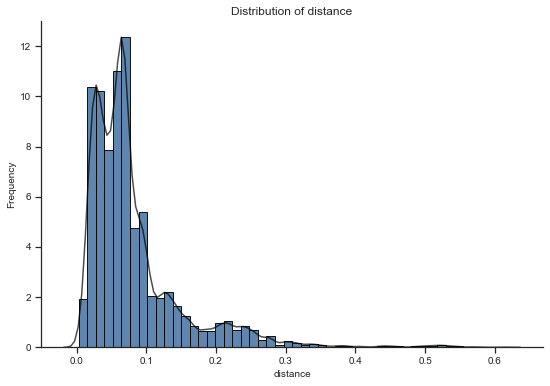

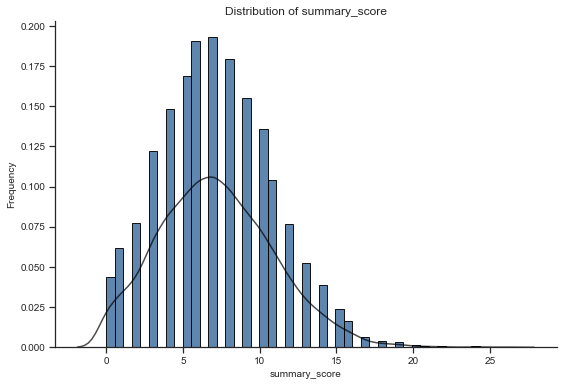

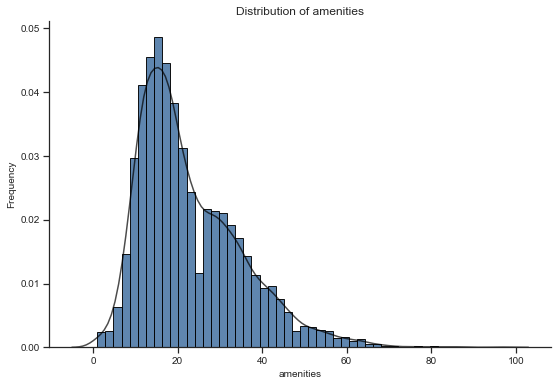

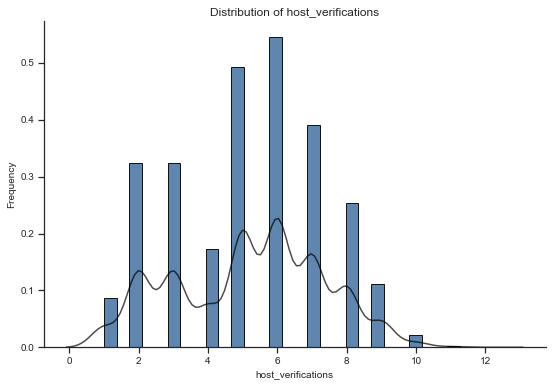

In [104]:
# Plot distribution charts for continuous variables
for i in range(len(numerical)):
    plot_dist(train_new[numerical[i]])
    my_big_fontsize = 10
    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = my_big_fontsize)
    plt.xlabel(str(numerical[i]), fontsize = my_big_fontsize)
    plt.ylabel('Frequency', fontsize = my_big_fontsize)
    plt.title("Distribution of "+str(numerical[i]))
    plt.show()

In [105]:
# log transformation on data that are skewed
train_dummy['distance'] = np.log (train_dummy['distance'])
train_dummy['amenities'] = np.log (train_dummy['amenities'])

In [106]:
test_dummy['distance'] = np.log (test_dummy['distance'])
test_dummy['amenities'] = np.log (test_dummy['amenities'])

**Check distribution after log transformation**

(<Figure size 648x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x23fd1830848>)

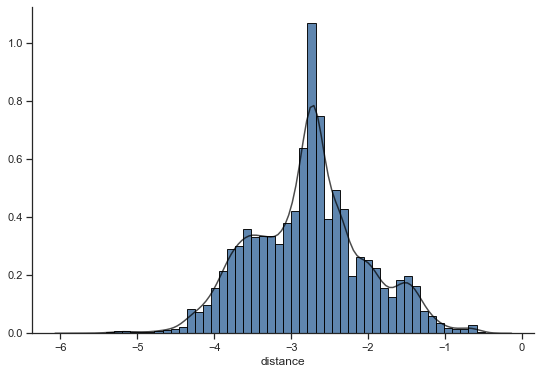

In [107]:
plot_dist(train_dummy['distance'])

(<Figure size 648x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x23fde6f8b48>)

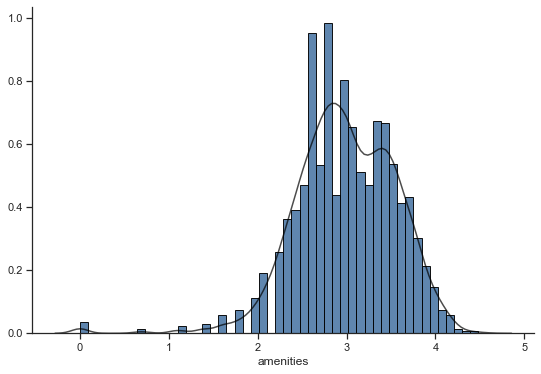

In [108]:
plot_dist(train_dummy['amenities'])

#### Satndadisation

In [109]:
#Standarize the data as regression model sensitive to scale
scaler = RobustScaler()
train_dummy_scaled=scaler.fit_transform(train_dummy)

# 4. Modeling

#### Split data into train and validation data

In [110]:
# define response variable
response=['price']

In [111]:
# define predictor variable
predictor=train_dummy.columns.tolist()
predictor.remove('price')

In [112]:
# Train validation set split
data = train_dummy.copy()
x_train = data[predictor].to_numpy()
y_train = data['price'].to_numpy()

data_test = test_dummy.copy()
x_test = data_test[predictor].to_numpy()

X_train,X_val,y_train,y_val = train_test_split(x_train,y_train,test_size=0.3,random_state=0)

## 4.1 Simple Linear Regression

In [113]:
# fit simple linear regression
ols = LinearRegression()
ols.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

## 4.2 Ridge

In [114]:
# fit model with best parameters
alphas = list(np.logspace(-15, 15, 151, base=2))
ridge = RidgeCV(alphas=alphas,normalize = [True,False])
ridge.fit(X_train, y_train)

RidgeCV(alphas=array([3.05175781e-05, 3.50554918e-05, 4.02681858e-05, 4.62559987e-05,
       5.31341897e-05, 6.10351562e-05, 7.01109836e-05, 8.05363715e-05,
       9.25119975e-05, 1.06268379e-04, 1.22070312e-04, 1.40221967e-04,
       1.61072743e-04, 1.85023995e-04, 2.12536759e-04, 2.44140625e-04,
       2.80443934e-04, 3.22145486e-04, 3.70047990e-04, 4.25073517e-04,
       4.88281250e-04, 5.60887869e-0...
       2.70235220e+03, 3.10418753e+03, 3.56577511e+03, 4.09600000e+03,
       4.70506846e+03, 5.40470440e+03, 6.20837506e+03, 7.13155021e+03,
       8.19200000e+03, 9.41013692e+03, 1.08094088e+04, 1.24167501e+04,
       1.42631004e+04, 1.63840000e+04, 1.88202738e+04, 2.16188176e+04,
       2.48335002e+04, 2.85262009e+04, 3.27680000e+04]),
        cv=None, fit_intercept=True, gcv_mode=None, normalize=[True, False],
        scoring=None, store_cv_values=False)

#### Diagnostic Plots

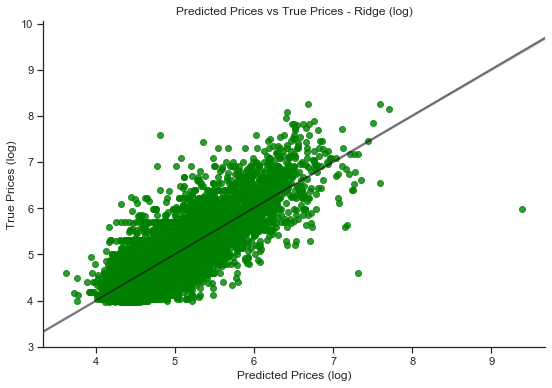

In [115]:
ridge_fitted = ridge.predict(X_train)
# Plot fitted values against true values
fig, ax = plt.subplots(figsize=(9,6))
sns.regplot(ridge_fitted, y_train, ci=50, line_kws={'color':'black', 'alpha':0.5}, ax = ax, color = 'g')
plt.savefig('Predicted Prices vs True Prices - Ridge (log)')
ax.set_xlabel('Predicted Prices (log)')
ax.set_ylabel('True Prices (log)')
ax.set_title('Predicted Prices vs True Prices - Ridge (log)')
sns.despine()
plt.show()

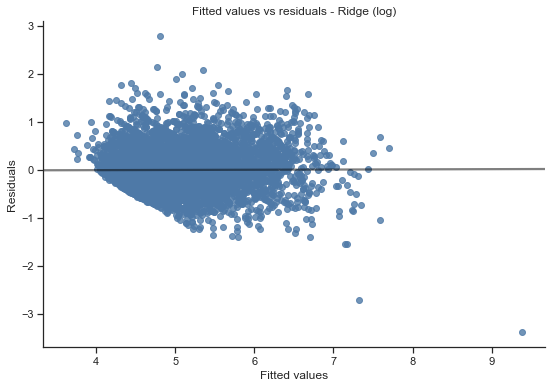

In [116]:
ridge_fitted = ridge.predict(X_train)
ridge_residual = y_train - ridge_fitted
# plot residual vs fitted values
fig, ax = plt.subplots(figsize=(9,6))
sns.regplot(ridge_fitted, ridge_residual, ci=None, line_kws={'color':'black', 'alpha':0.5}, ax = ax)
plt.savefig('Residual Plot for Ridge Regularized Regression (log)')
ax.set_xlabel('Fitted values')
ax.set_ylabel('Residuals')
ax.set_title('Fitted values vs residuals - Ridge (log)')
sns.despine()
plt.show()

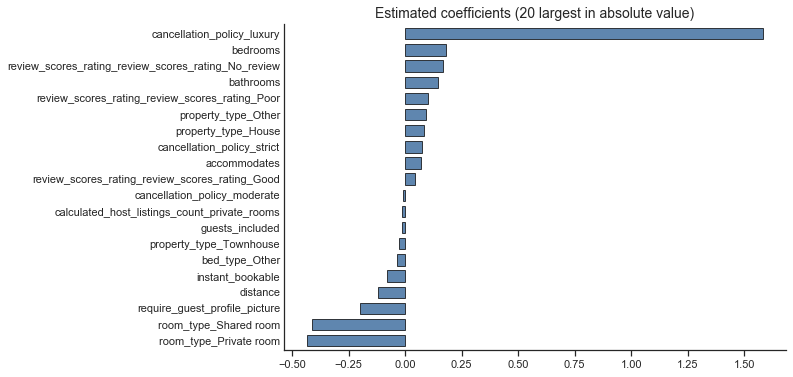

In [117]:
# plot coefficients
plot_coefficients(ridge, predictor)
plt.show()

## 4.3 Lasso

In [118]:
# fit model with best parameters
lasso = LassoCV(cv=5, alphas=alphas,normalize = [True,False])
lasso.fit(X_train, y_train)

LassoCV(alphas=[3.0517578125e-05, 3.505549179068098e-05, 4.026818575356734e-05,
                4.625599873383782e-05, 5.313418965430448e-05, 6.103515625e-05,
                7.011098358136196e-05, 8.053637150713468e-05,
                9.251199746767564e-05, 0.00010626837930860896, 0.0001220703125,
                0.00014022196716272393, 0.00016107274301426937,
                0.0001850239949353513, 0.0002125367586172179, 0.000244140625,
                0.0...
                0.000740095979741406, 0.0008501470344688716, 0.0009765625,
                0.0011217757373017914, 0.001288581944114155,
                0.001480191959482812, 0.0017002940689377433, ...],
        copy_X=True, cv=5, eps=0.001, fit_intercept=True, max_iter=1000,
        n_alphas=100, n_jobs=None, normalize=[True, False], positive=False,
        precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
        verbose=False)

In [119]:
len(predictor)-np.sum(lasso.coef_==0.0)

22

#### Diagnostic Plots

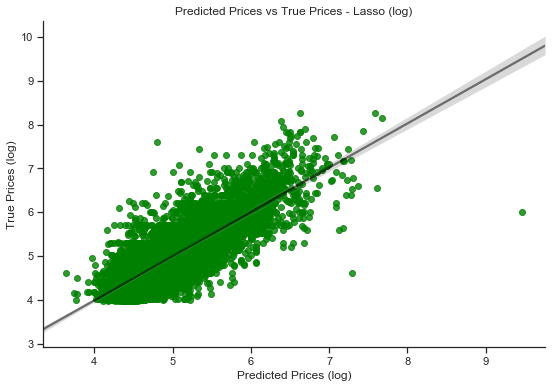

In [120]:
lasso_fitted = lasso.predict(X_train)
# Plot fitted values against true values
fig, ax = plt.subplots(figsize=(9,6))
sns.regplot(lasso_fitted, y_train, ci=100, line_kws={'color':'black', 'alpha':0.5}, ax = ax, color = 'g')
plt.savefig('Predicted Prices vs True Prices - Lasso (log)')
ax.set_xlabel('Predicted Prices (log)')
ax.set_ylabel('True Prices (log)')
ax.set_title('Predicted Prices vs True Prices - Lasso (log)')
sns.despine()
plt.show()

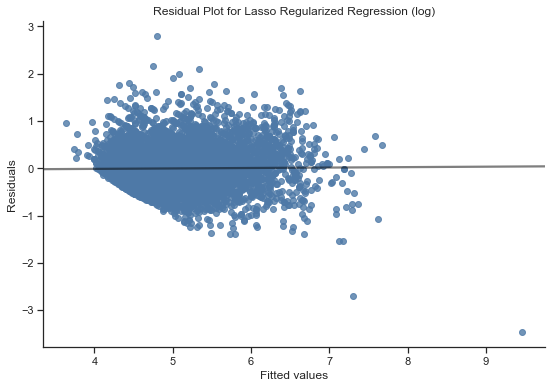

In [121]:
lasso_fitted = lasso.predict(X_train)
lasso_residual = y_train - lasso_fitted
# plot residual vs fitted values
fig, ax = plt.subplots(figsize=(9,6))
sns.regplot(lasso_fitted, lasso_residual, ci=None, line_kws={'color':'black', 'alpha':0.5}, ax = ax)
plt.savefig('Residual Plot for Lasso Regularized Regression (log)')
ax.set_xlabel('Fitted values')
ax.set_ylabel('Residuals')
ax.set_title('Residual Plot for Lasso Regularized Regression (log)')
sns.despine()
plt.show()

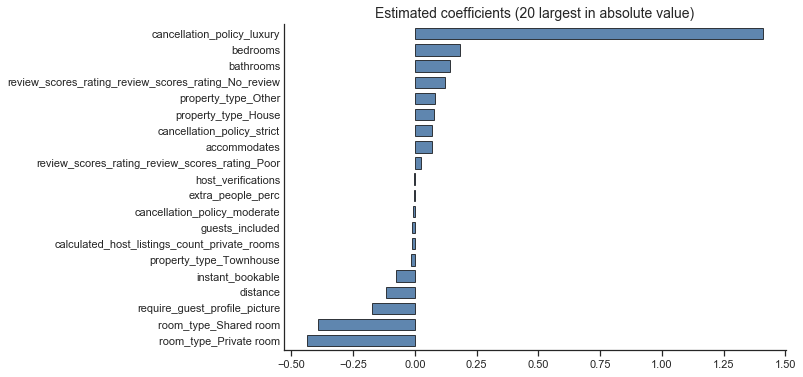

In [122]:
# plot coefficients
plot_coefficients(lasso, predictor)
plt.show()

## 4.4 Elastic Net

In [123]:
# fit model with search for best parameter using pipeline
enet = Pipeline((
    ('scaler', StandardScaler()),
    ('estimator', ElasticNetCV(l1_ratio=[0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9, 0.99], cv=5)),
))

enet.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('estimator',
                 ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001,
                              fit_intercept=True,
                              l1_ratio=[0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,
                                        0.8, 0.9, 0.99],
                              max_iter=1000, n_alphas=100, n_jobs=None,
                              normalize=False, positive=False,
                              precompute='auto', random_state=None,
                              selection='cyclic', tol=0.0001, verbose=0))],
         verbose=False)

## 4.5 GBM

In [124]:
%%time
model = GradientBoostingRegressor()

tuning_parameters = {
    'learning_rate': [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1],
    'n_estimators' : [100,150,200,250,500,750,1000,1500,2000],
    'max_depth' : [2,3,4,5,6,7,8,9],
    'subsample' : [0.4,0.6,0.7,0.8,0.9,1.0]
}

# Using RandomizedSearch to increase speed
gb = RandomizedSearchCV(model, tuning_parameters, n_iter = 32, cv = 5, n_jobs=-1, random_state=87,
                       scoring='neg_mean_squared_error')
# fit the model
gb.fit(X_train, y_train)

print('Best parameters found by randomised search:', gb.best_params_, '\n')

Best parameters found by randomised search: {'subsample': 0.9, 'n_estimators': 1500, 'max_depth': 2, 'learning_rate': 0.03} 

Wall time: 4min 39s


## 4.6 XGBoost

In [125]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [126]:
%%time
import xgboost as xgb
model = xgb.XGBRegressor(objective='reg:squarederror')

tuning_parameters = {
    'reg_lambda': [0,1],
    'reg_alpha': [0,1],
    'learning_rate': [0.01,0.02,0.03,0.04, 0.05,0.06,0.07,0.08,0.09,0.1],
    'n_estimators' : [100,150,200,250, 500, 750, 1000, 1500, 2000],
    'max_depth' : [2 ,3, 4,5,6,7,8,9],
    'subsample' : [0.4,0.6,0.7, 0.8,0.9, 1.0]
}

xbst_search = RandomizedSearchCV(model, tuning_parameters, n_iter = 32, cv = 5, random_state=87, 
                          n_jobs=-1,scoring='neg_mean_squared_error')

xbst_search.fit(X_train, y_train)

xbst = xbst_search.best_estimator_

print('Best parameters found by randomised search:', xbst_search.best_params_, '\n')

Best parameters found by randomised search: {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 1, 'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.02} 

Wall time: 3min 37s


#### Diagnostic plots

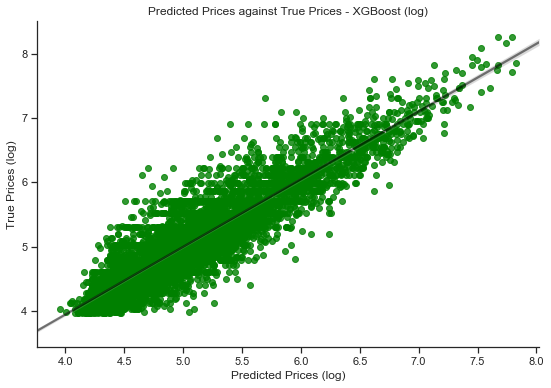

In [127]:
xbst_fitted = xbst.predict(X_train)
# Plot fitted values against true values
fig, ax = plt.subplots(figsize=(9,6))
sns.regplot(xbst_fitted, y_train, ci=100, line_kws={'color':'black', 'alpha':0.5}, ax = ax, color = 'g')
plt.savefig('Predicted Prices against True Prices - XGBoost (log)')
ax.set_xlabel('Predicted Prices (log)')
ax.set_ylabel('True Prices (log)')
ax.set_title('Predicted Prices against True Prices - XGBoost (log)')
sns.despine()
plt.show()

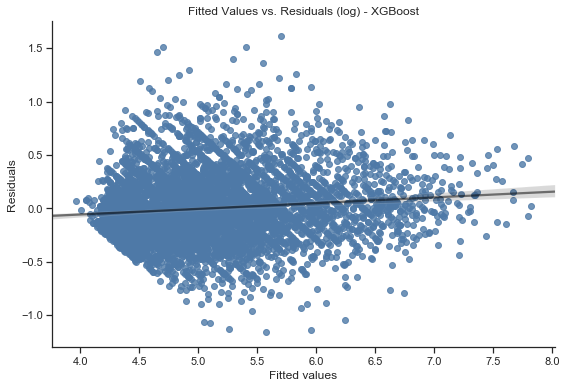

In [128]:
xbst_fitted = xbst.predict(X_train)
xbst_residual = y_train - xbst_fitted
# plot residual vs fitted values
fig, ax = plt.subplots(figsize=(9,6))
sns.regplot(xbst_fitted, xbst_residual, ci=100, line_kws={'color':'black', 'alpha':0.5}, ax = ax)
plt.savefig('Residual Plot for XGBoost Regression (log)')
ax.set_xlabel('Fitted values')
ax.set_ylabel('Residuals')
ax.set_title('Fitted Values vs. Residuals (log) - XGBoost')
sns.despine()
plt.show()

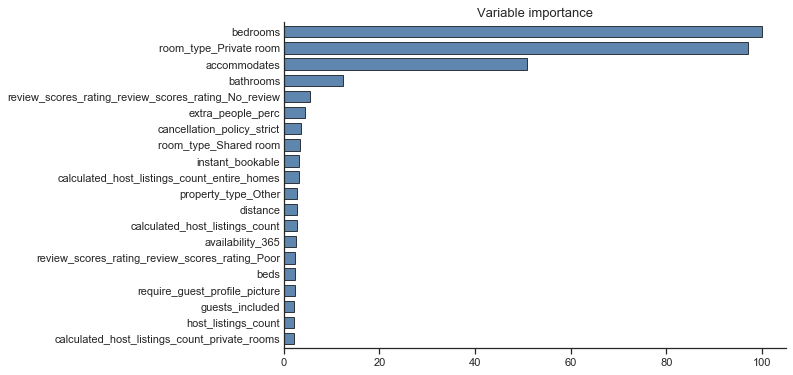

In [129]:
# Plot the coefficients
plot_feature_importance(xbst, labels=predictor)
plt.savefig('Estimated Coefficients - XGBoost.pdf',format = 'pdf')
plt.show()

## 4.7 LightGBM

In [130]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [131]:
import lightgbm as lgb

In [132]:
%%time
model = lgb.LGBMRegressor(objective='regression')

tuning_parameters = {
    'learning_rate': [0.01,0.02,0.03,0.04, 0.05,0.06,0.07,0.08,0.09,0.1],
    'n_estimators' : [100,150,200,250,500,750,1000,1500,2000],
    'num_leaves' : list(np.arange(2,64)),
    'subsample' : [0.4,0.6,0.7,0.8,0.9,1.0],
}


lbst = RandomizedSearchCV(model, tuning_parameters, n_iter = 32, cv = 5, n_jobs=-1, 
                          random_state=87,scoring='neg_mean_squared_error')
lbst.fit(X_train, y_train)

print('Best parameters found by randomised search:', lbst.best_params_, '\n')

Best parameters found by randomised search: {'subsample': 1.0, 'num_leaves': 13, 'n_estimators': 2000, 'learning_rate': 0.01} 

Wall time: 38.1 s


## 4.8 Decision Tree

In [133]:
%%time

# Optimise the hyperparameters
model_dt = DecisionTreeRegressor()

tuning_parameters = {
    'min_samples_leaf': [1,5,10,20,30,40,50,60,70,80,90,100,150,300,500],
    'max_depth': np.arange(1,50)
}

tree_search = GridSearchCV(model_dt, tuning_parameters, cv = 10 , scoring='neg_mean_squared_error')
tree_search.fit(X_train, y_train)

tree = tree_search.best_estimator_

print('Best parameters found by grid search:', tree_search.best_params_, '\n')

Best parameters found by grid search: {'max_depth': 7, 'min_samples_leaf': 10} 

Wall time: 2min 27s


## 4.9 Bagging

In [134]:
# Fit model with best parameter
bag = BaggingRegressor(DecisionTreeRegressor(), n_estimators=1000, random_state=1)
bag.fit(X_train, y_train)

BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                      max_depth=None,
                                                      max_features=None,
                                                      max_leaf_nodes=None,
                                                      min_impurity_decrease=0.0,
                                                      min_impurity_split=None,
                                                      min_samples_leaf=1,
                                                      min_samples_split=2,
                                                      min_weight_fraction_leaf=0.0,
                                                      presort=False,
                                                      random_state=None,
                                                      splitter='best'),
                 bootstrap=True, bootstrap_features=False, max_features=1.0,
                 max_sample

## 4.10 Random Forest

In [135]:
%%time
# Select the hyperparameters

model_rf = RandomForestRegressor()

xtrain = pd.DataFrame(X_train)
tuning_parameters_rf = {
    'n_estimators': [50,100,200,500,1000,1500],
    'min_samples_leaf': [1,5,10,20,50],
    'max_features': np.arange(1, len(xtrain.columns)+1),
}

rf_search = RandomizedSearchCV(model_rf, tuning_parameters_rf, n_iter= 64, cv = 5, n_jobs = -1, 
                               scoring = 'neg_mean_squared_error', return_train_score=False,
                               random_state=1)
rf_search.fit(X_train, y_train)

rf = rf_search.best_estimator_

print('Best parameters found by randomised search:', rf_search.best_params_, '\n')

Best parameters found by randomised search: {'n_estimators': 1500, 'min_samples_leaf': 1, 'max_features': 7} 

Wall time: 5min 28s


# 5. Model Evaluation
**Forecast result**

In [136]:
# OLS 
ols_pred = ols.predict(X_val)
ols_RMSE = np.sqrt(mean_squared_error(y_val, ols_pred))
ols_r2 = r2_score(y_val, ols_pred)

# Ridge 
l2_pred = ridge.predict(X_val)
l2_RMSE = np.sqrt(mean_squared_error(y_val, l2_pred))
l2_r2 = r2_score(y_val, l2_pred)

# Lasso 
l1_pred = lasso.predict(X_val)
l1_RMSE = np.sqrt(mean_squared_error(y_val, l1_pred))
l1_r2 = r2_score(y_val, l1_pred)

# Elastic net
enet_pred = enet.predict(X_val)
enet_RMSE = np.sqrt(mean_squared_error(y_val, enet_pred))
enet_r2 = r2_score(y_val, enet_pred)

# Gradient Boosting
gb_pred = gb.predict(X_val)
gb_RMSE = np.sqrt(mean_squared_error(y_val, gb_pred))
gb_r2 = r2_score(y_val, gb_pred)

# XGBoost
xbst_pred = xbst.predict(X_val)
xbst_RMSE = np.sqrt(mean_squared_error(y_val, xbst_pred))
xbst_r2 = r2_score(y_val, xbst_pred)

# Light GBM
lbst_pred = lbst.predict(X_val)
lbst_RMSE = np.sqrt(mean_squared_error(y_val, lbst_pred))
lbst_r2 = r2_score(y_val, xbst_pred)

# Decission tree 
tree_pred = tree.predict(X_val)
tree_RMSE = np.sqrt(mean_squared_error(y_val, tree_pred))
tree_r2 = r2_score(y_val, tree_pred)

# Bagging
bag_pred = bag.predict(X_val)
bag_RMSE = np.sqrt(mean_squared_error(y_val, bag_pred))
bag_r2 = r2_score(y_val, bag_pred)

# Random Forest
rf_pred = rf.predict(X_val)
rf_RMSE = np.sqrt(mean_squared_error(y_val, rf_pred))
rf_r2 = r2_score(y_val, rf_pred)

**Measure Performance**

In [138]:
# put evaluation results in one table
columns=['RMSE','R Square']
rows=['Linear Regression','Ridge',' Lasso ','Enet','Gradient Boosting','XGBoost','Light GBM','Decision Tree','Bagging','Random Forest']
results=pd.DataFrame(0.0, columns=columns, index=rows)

results.iloc[0,0] =  ols_RMSE.round(3)
results.iloc[1,0] =  l2_RMSE.round(3)
results.iloc[2,0] =  l1_RMSE.round(3)
results.iloc[3,0] =  enet_RMSE.round(3)
results.iloc[4,0] =  gb_RMSE.round(3)  
results.iloc[5,0] =  xbst_RMSE.round(3)
results.iloc[6,0] =  lbst_RMSE.round(3) 
results.iloc[7,0] =  tree_RMSE.round(3)
results.iloc[8,0] =  bag_RMSE.round(3)
results.iloc[9,0] =  rf_RMSE.round(3)
results.iloc[0,1] =  ols_r2.round(3)
results.iloc[1,1] =  l2_r2.round(3)
results.iloc[2,1] =  l1_r2.round(3)
results.iloc[3,1] =  enet_r2.round(3)
results.iloc[4,1] =  gb_r2.round(3)  
results.iloc[5,1] =  xbst_r2.round(3)
results.iloc[6,1] =  lbst_r2.round(3) 
results.iloc[7,1] =  tree_r2.round(3)
results.iloc[8,1] =  bag_r2.round(3)
results.iloc[9,1] =  rf_r2.round(3)

results

,RMSE,R Square
Linear Regression,0.417,0.642
Ridge,0.417,0.642
Lasso,0.418,0.642
Enet,0.417,0.642
Gradient Boosting,0.376,0.709
XGBoost,0.371,0.717
Light GBM,0.372,0.717
Decision Tree,0.422,0.634
Bagging,0.384,0.697
Random Forest,0.379,0.705


## Submission

In [139]:
# XGBoost submission (final model)
xbst_pred = xbst.predict(x_test)
y_pred = (np.exp(xbst_pred)-1).round(0).astype(int)

submission = pd.DataFrame(np.c_[test_dummy.index, y_pred], columns=['id', 'price'])
submission['id'] = submission['id'].astype('int')
submission.to_csv('xbst.csv', index=False) 

In [140]:
# OLS submission
ols_pred = ols.predict(x_test)
y_pred = (np.exp(ols_pred)-1).round(0).astype(int)

submission = pd.DataFrame(np.c_[test_dummy.index, y_pred], columns=['id', 'price'])
submission['id'] = submission['id'].astype('int')
submission.to_csv('ols.csv', index=False) 

In [141]:
# Ridge submission
ridge_pred = ridge.predict(x_test)
y_pred = (np.exp(ridge_pred)-1).round(0).astype(int)

submission = pd.DataFrame(np.c_[test_dummy.index, y_pred], columns=['id', 'price'])
submission['id'] = submission['id'].astype('int')
submission.to_csv('ridge.csv', index=False) 

In [142]:
# Lasso submission
lasso_pred = lasso.predict(x_test)
y_pred = (np.exp(lasso_pred)-1).round(0).astype(int)

submission = pd.DataFrame(np.c_[test_dummy.index, y_pred], columns=['id', 'price'])
submission['id'] = submission['id'].astype('int')
submission.to_csv('lasso.csv', index=False) 

In [143]:
# Elastic net submission
enet_pred = enet.predict(x_test)
y_pred = (np.exp(enet_pred)-1).round(0).astype(int)

submission = pd.DataFrame(np.c_[test_dummy.index, y_pred], columns=['id', 'price'])
submission['id'] = submission['id'].astype('int')
submission.to_csv('enet.csv', index=False) 

In [144]:
# Gradient Boosting submission
gb_pred = gb.predict(x_test)
y_pred = (np.exp(gb_pred)-1).round(0).astype(int)

submission = pd.DataFrame(np.c_[test_dummy.index, y_pred], columns=['id', 'price'])
submission['id'] = submission['id'].astype('int')
submission.to_csv('gb.csv', index=False) 

In [145]:
# Light GBM submission
lbst_pred = lbst.predict(x_test)
y_pred = (np.exp(lbst_pred)-1).round(0).astype(int)

submission = pd.DataFrame(np.c_[test_dummy.index, y_pred], columns=['id', 'price'])
submission['id'] = submission['id'].astype('int')
submission.to_csv('lbst.csv', index=False) 

In [146]:
# Decision tree submission
tree_pred = tree.predict(x_test)
y_pred = (np.exp(tree_pred)-1).round(0).astype(int)

submission = pd.DataFrame(np.c_[test_dummy.index, y_pred], columns=['id', 'price'])
submission['id'] = submission['id'].astype('int')
submission.to_csv('tree.csv', index=False) 

In [147]:
# Bagging submission
bag_pred = bag.predict(x_test)
y_pred = (np.exp(bag_pred)-1).round(0).astype(int)

submission = pd.DataFrame(np.c_[test_dummy.index, y_pred], columns=['id', 'price'])
submission['id'] = submission['id'].astype('int')
submission.to_csv('bag.csv', index=False) 

In [148]:
# Random forest submission
rf_pred = rf.predict(x_test)
y_pred = (np.exp(rf_pred)-1).round(0).astype(int)

submission = pd.DataFrame(np.c_[test_dummy.index, y_pred], columns=['id', 'price'])
submission['id'] = submission['id'].astype('int')
submission.to_csv('rf.csv', index=False) 